In [1]:
import pandas as pd
import numpy as np
import regex as re

from collections import Counter

from useful_functions import *

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Load the main datasets:
q1_date_df = pickle_loader("q1_date_df")
q1_jrnl_df = pickle_loader("q1_jrnl_df")
q1_first_author_df = pickle_loader("q1_first_author_df")

### Part 1: Cleaning both datasets

#### TTD 1:

In [3]:
q1_date_df["publ_year"] = q1_date_df.published.map(lambda x: x["date-parts"][0][0])

In [ ]:
q1_date_df[q1_date_df.publ_year != q1_date_df.JRNL_YEAR]

# 3 articles!

Will change the JRNL_ID's manually.

In [14]:
# Fix:

q1_date_df.loc["10.1525/mp.2014.31.4.372","JRNL_YEAR"] = 2014
q1_date_df.loc["10.1525/mp.2014.31.4.372","JRNL_ID"] = "1_15781"

q1_date_df.loc["10.1525/mp.2012.29.3.285","JRNL_YEAR"] = 2012
q1_date_df.loc["10.1525/mp.2012.29.3.285","JRNL_ID"] = "1_15782"

q1_date_df.loc["10.1525/mp.2012.29.3.255","JRNL_YEAR"] = 2012
q1_date_df.loc["10.1525/mp.2012.29.3.255","JRNL_ID"] = "1_15782"


In [17]:
# Drop unnec. col:
q1_date_df.drop("publ_year", axis=1, inplace=True)

#### TTD 2:

In [18]:
q1_date_df["Submitted_Date"] = q1_date_df.Dates.map(lambda x: x[0])
q1_date_df["Accepted_Date"] = q1_date_df.Dates.map(lambda x: x[1])

q1_date_df["Published_Date"] = q1_date_df.published.map(lambda x: x["date-parts"][0])

In [37]:
def main_subd_converter(sub_d):
    try:
        if bool(re.search("[A-Za-z]",sub_d)):
            try:
                return pd.to_datetime(sub_d, infer_datetime_format=True)
            except:
                sub_d = re.sub('(\d+(\.\d+)?)', r' \1', sub_d)
                return pd.to_datetime(sub_d, infer_datetime_format=True)

        else:
            try:
                return pd.to_datetime(sub_d, format='%d-%m-%Y')
            except:
                return pd.to_datetime(sub_d, format='%d.%m.%Y')
    except:
        return np.nan

In [38]:
q1_date_df["Submitted_datetime"] = q1_date_df.Submitted_Date.map(main_subd_converter)

In [43]:
q1_date_df[q1_date_df.Submitted_datetime.isna()].Submitted_Date.to_list()

['16 Juny 2017', '00 November 2016']

In [44]:
q1_date_df[q1_date_df.Submitted_datetime.isna()].direct_url.to_list()

['https://sci.bban.top/pdf/10.3144/expresspolymlett.2018.8.pdf#view=FitH',
 'https://sci.bban.top/pdf/10.1016/j.patrec.2016.12.011.pdf#view=FitH']

There are only 2 articles that have actually incorrectly written dates.

They will be dropped after the next step.

In [47]:
q1_date_df.Published_Date.map(len).value_counts()

3    103177
2     77200
1      6125
Name: Published_Date, dtype: int64

In [53]:
# Need to fix missing publ. date columns:

# If missing, will fill with middle values

def publ_date_filler(pub_d):
    if len(pub_d) == 3:
        return pub_d
    elif len(pub_d) == 2:
        pub_d.append(15)
        return pub_d
    elif len(pub_d) == 1:
        pub_d.append(6)
        pub_d.append(15)
        return pub_d


In [56]:
q1_date_df["Published_datetime"] = q1_date_df.Published_Date.map(publ_date_filler)

In [57]:
q1_date_df["Published_datetime"] = q1_date_df.Published_datetime.map(lambda x: "-".join([str(it) for it in x])).map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

In [60]:
len(q1_date_df[q1_date_df.Submitted_datetime > q1_date_df.Published_datetime])

1829

The new function decreased the number to 1829

#### TTD 3: 

In [ ]:
first_auth_fix_df = pickle_loader("q1_first_author_df")

first_auth_fix_df.dropna(subset="country")[(first_auth_fix_df.dropna(subset="country").country.map(lambda x: None in x)) & (first_auth_fix_df.dropna(subset="country").country.map(len) == 1)]

In [ ]:
q1_first_author_df.loc[:,"index"] = q1_first_author_df.index.map(lambda x: "aut_" + str(x))
q1_first_author_df.set_index("index", inplace=True)

#  Creating a auth & doi mapping dict w/ only valid authors considered:

q1_first_author_df.loc[q1_first_author_df.country.notna(),"consider"] = q1_first_author_df[q1_first_author_df.country.notna()].country.map(lambda x: True if len(x)>0 else False)
q1_first_author_df.consider.fillna(False, inplace=True)

doi_aut_dict = dict()

for aut_id, row in q1_first_author_df[q1_first_author_df.consider == True].iterrows():
    doi_list = row["DOI"]
    for doi in doi_list:
        if doi in doi_aut_dict.keys():
            doi_aut_dict[doi].append(aut_id)
        else:
            doi_aut_dict[doi] = [aut_id]


In [64]:
len(doi_aut_dict)

176841

In [65]:
q1_date_df["AUTH_ID"] = q1_date_df.index.map(doi_aut_dict)

TDD 3 is also complete! Now need to filter out q1_date_df accordingly


#### TDD 4: q1_date_df updates

In [77]:
# year_mask = q1_date_df_wip.publ_year == q1_date_df_wip.JRNL_YEAR
prob_subd_mask = q1_date_df.Submitted_datetime.notna()
subm_publ_mask = q1_date_df.Submitted_datetime < q1_date_df.Published_datetime
auth_mask = q1_date_df.AUTH_ID.notna()

In [75]:
len(q1_date_df[prob_subd & subm_publ_mask & auth_mask])

175092

In [76]:
del aut_id
del doi
del doi_list
del prob_subd
del row
del testo

After the main proper filtering, we are left with 175,092 articles.

The "old" date_df is saved as before_8b_masking.

q1_date_df can now be updated.

The rest will also be added to remainder_df.

In [78]:
# remainder_df updates:

q1_remainder_df = pickle_loader("q1_remainder_df")
q1_remainder_df = pd.concat([q1_remainder_df, q1_date_df[~(prob_subd_mask & subm_publ_mask & auth_mask)]])
pickle_dumper(q1_remainder_df, "q1_remainder_df")

In [87]:
q1_date_df = q1_date_df[prob_subd_mask & subm_publ_mask & auth_mask]

In [99]:
pickle_dumper(q1_date_df, "q1_date_df_after_8b_masking_Aug10")

q1_date_df is now up-to-date row-wise.

Will also analyse the column to simplify:

Columns to drop:
ISSN, JRNL_YEAR, Dates



In [101]:
q1_date_df = q1_date_df[['JRNL_ID', 'issued', 'container-title', 'publisher', 'title',
       'author', 'subject', 'references-count', 'is-referenced-by-count',
       'published', 'published-print', 'published-online', 'direct_url',
       'Keywords', 'Chosen_SA', 'AUTH_ID', 'Submitted_Date',
       'Accepted_Date', 'Published_Date', 'Submitted_datetime',
       'Published_datetime']]

In [137]:
q1_date_df[q1_date_df.AUTH_ID.map(len) == 539]

,JRNL_ID,issued,container-title,publisher,title,author,subject,references-count,is-referenced-by-count,published,...,published-online,direct_url,Keywords,Chosen_SA,AUTH_ID,Submitted_Date,Accepted_Date,Published_Date,Submitted_datetime,Published_datetime
DOI,,,,,,,,,,,,,,,,,,,,,
10.1093/ptep/ptaa008,1_62111,"{'date-parts': [[2020, 2, 1]]}",[Progress of Theoretical and Experimental Phys...,Oxford University Press (OUP),[The Belle II Physics Book],"[{'given': 'E', 'family': 'Kou', 'sequence': '...",[General Physics and Astronomy],0.0,87,"{'date-parts': [[2020, 2, 28]]}",...,"{'date-parts': [[2020, 2, 28]]}",https://sci.bban.top/pdf/10.1093/ptep%252Fptaa...,"[(phys, 0.3882), (physics, 0.3817), (studies, ...",Physics and Astronomy,"[aut_7, aut_25, aut_39, aut_42, aut_47, aut_61...","January 21, 2020","January 21, 2020","[2020, 2, 28]",2020-01-21,2020-02-28


There is a book within the dataset, as seen above. This will also be dropped.

In [139]:
q1_date_df.drop("10.1093/ptep/ptaa008", inplace=True)

In [140]:
pickle_dumper(q1_date_df, "q1_date_df")

#### TDD 5: q1_first_author_df updates - (NONE fix & re-filtering q1_date_df)

In [141]:
usefeul_auths_list = q1_date_df.AUTH_ID.to_list()
usefeul_auths_list = flatten(usefeul_auths_list)
usefeul_auths_list = list(set(usefeul_auths_list))

In [144]:
len(usefeul_auths_list)

167591

In [143]:
q1_first_author_df = q1_first_author_df.loc[usefeul_auths_list,:].sort_index()

In [145]:
q1_first_author_df.country.map(len).value_counts()

1     129433
2      15398
3       5260
25      4657
4       2877
5       1846
6       1302
7       1012
8        790
9        642
10       535
11       483
12       449
13       371
14       334
15       292
19       255
17       250
16       243
24       220
20       209
18       203
22       185
23       176
21       169
Name: country, dtype: int64

In [146]:
q1_first_author_df["country_count"] = q1_first_author_df.country.map(Counter)

In [147]:
q1_first_author_df["most_common_country"] = q1_first_author_df.country_count.map(lambda x: x.most_common()[0][0])

In [148]:
q1_first_author_df["first_country"] = q1_first_author_df.country.map(lambda x: x[0])

In [149]:
len(q1_first_author_df[q1_first_author_df.first_country != q1_first_author_df.most_common_country])

5645

5645 authors have "conflicting" infos. In these cases, as the first results have the highest number of articles, first_country will be selected!

Therfore, first_country will be used in general!



In [155]:
len(q1_first_author_df[q1_first_author_df.first_country.isnull()])

587

In [153]:
q1_first_author_df.loc["aut_100004"]

new_given                                             nitin
new_family                                            karwa
SA_list                [Physics and Astronomy, Engineering]
DOI                    [10.1016/j.ijthermalsci.2011.01.021]
country                                              [None]
given                                               [Nitin]
family                                              [Karwa]
doc_count                                              [23]
consider                                               True
country_count                                     {None: 1}
most_common_country                                    None
first_country                                          None
Name: aut_100004, dtype: object

Just realized, there are 587 authors that do not have country info but retrieved as  [None].

These will be ANALYZED & dropped as well.

__NONE FIX:__

In [174]:
# Dropping authors with only None country:

q1_first_author_df = q1_first_author_df[~((q1_first_author_df.country.map(lambda x: None in x)) & (q1_first_author_df.country.map(len)== 1))]

In [175]:
# Fixing first_country with None:

def valid_first_country_picker(cnt_list):
    for cntry in cnt_list:
        if cntry == None:
            pass
        else:
            return cntry

In [180]:
q1_first_author_df["valid_first_country"] = q1_first_author_df.country.map(valid_first_country_picker)

<ipython-input-180-81cc6e5dfa70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_first_author_df["valid_first_country"] = q1_first_author_df.country.map(valid_first_country_picker)


In [181]:
# Fixing most_common_country with None:

def valid_most_common_country_picker(cnt_tuple):
    for cntry in cnt_tuple:
        if cntry[0] == None:
            pass
        else:
            return cntry[0]

In [182]:
q1_first_author_df["valid_most_common_country"] = q1_first_author_df.country_count.map(lambda x: valid_most_common_country_picker(x.most_common()))

<ipython-input-182-c85e322dd8df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_first_author_df["valid_most_common_country"] = q1_first_author_df.country_count.map(lambda x: valid_most_common_country_picker(x.most_common()))


In [184]:
len(q1_first_author_df[q1_first_author_df.valid_most_common_country != q1_first_author_df.most_common_country])

54

In [185]:
len(q1_first_author_df[q1_first_author_df.valid_first_country != q1_first_author_df.first_country])

89

The only None authors are dropped and others are fixed. Now we need to re-create doi_aut_dict with the up-to-date q1_first_author_df.

We can then use this dict to re-create AUTH_ID column for q1_date_df.

And finally, drop any articles that do not have any associated authors.

In [186]:
doi_aut_dict_new = dict()

for aut_id, row in q1_first_author_df.iterrows():
    doi_list = row["DOI"]
    for doi in doi_list:
        if doi in doi_aut_dict_new.keys():
            doi_aut_dict_new[doi].append(aut_id)
        else:
            doi_aut_dict_new[doi] = [aut_id]

In [188]:
# New AUTH_ID column:

q1_date_df["AUTH_ID"] = q1_date_df.index.map(doi_aut_dict_new)

In [191]:
# Removing no AUTH'd articles:

q1_date_df = q1_date_df[q1_date_df.AUTH_ID.notna()]

In [193]:
q1_date_df.AUTH_ID.map(len).value_counts()

1     173440
2        298
3        269
4        235
5        109
6         97
7         41
8         34
9         23
10        11
12         6
11         5
17         2
15         2
20         2
22         1
21         1
13         1
14         1
32         1
Name: AUTH_ID, dtype: int64

In [194]:
usefeul_auths_list_new = q1_date_df.AUTH_ID.to_list()
usefeul_auths_list_new = flatten(usefeul_auths_list_new)
usefeul_auths_list_new = list(set(usefeul_auths_list_new))

In [195]:
len(usefeul_auths_list_new)

167093

The len is same as the df & no need to re-filter q1_first_author_df

In [198]:
q1_first_author_df.head()

,new_given,new_family,SA_list,DOI,country,given,family,doc_count,consider,country_count,most_common_country,first_country,valid_first_country,valid_most_common_country
index,,,,,,,,,,,,,,
aut_0,jing,cai,"[Social Sciences, Arts and Humanities]",[10.1016/j.jeap.2016.09.002],"[China, China, China, Hong Kong]","[Jing, Jingheng, Jing, (Luna) Jing]","[Cai, Cai, Cai, Cai]","[23, 22, 1, 1]",True,"{'China': 3, 'Hong Kong': 1}",China,China,China,China
aut_1,qing,hao,"[Economics, Econometrics and Finance]",[10.1016/j.finmar.2015.11.003],"[United States, United States, United States, ...","[Qing, Qing, (Grace) Qing, Grace Qing]","[Hao, Hao, Hao, Hao]","[86, 11, 2, 1]",True,{'United States': 4},United States,United States,United States,United States
aut_10,A.,anav,[Environmental Science],[10.3354/cr00993],"[Italy, Italy]","[Alessandro, Andrea]","[Anav, Anav]","[52, 9]",True,{'Italy': 2},Italy,Italy,Italy,Italy
aut_100,A.,kuzmin,"[Physics and Astronomy, Neuroscience, Medicine]","[10.1093/ptep/ptaa008, 10.1038/tp.2013.72]","[Russian Federation, United States]","[Vladimir, Andrey N.]","[Kuzmin, Kuzmin]","[338, 102]",True,"{'Russian Federation': 1, 'United States': 1}",Russian Federation,Russian Federation,Russian Federation,Russian Federation
aut_10000,alexander,mckelvie,"[Business, Management and Accounting]",[10.1016/j.jbusvent.2009.10.004],[United States],[Alexander],[McKelvie],[50],True,{'United States': 1},United States,United States,United States,United States


In [199]:
q1_first_author_df.drop(["consider","most_common_country","first_country"], axis=1, inplace=True)

<ipython-input-199-52f00a48aa5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_first_author_df.drop(["consider","most_common_country","first_country"], axis=1, inplace=True)


In [201]:
q1_first_author_df.rename(columns={"valid_first_country": "first_country", "valid_most_common_country": "most_common_country"}, inplace=True)

<ipython-input-201-95910abafc24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_first_author_df.rename(columns={"valid_first_country": "first_country", "valid_most_common_country": "most_common_country"}, inplace=True)


A single prob. author is remaining.

Will drop manually.

In [205]:
q1_first_author_df[q1_first_author_df.first_country.isnull()]

,new_given,new_family,SA_list,DOI,country,given,family,doc_count,country_count,first_country,most_common_country
index,,,,,,,,,,,
aut_16955,arnaud,dupuy,"[Economics, Econometrics and Finance, Economic...","[10.1080/10438590903434836, 10.1111/ecca.12071]","[None, None]","[Arnaud, Arnaud]","[Dupuy, Dupuy]","[24, 2]",{None: 2},None,None


In [208]:
q1_first_author_df.drop("aut_16955", inplace=True)

<ipython-input-208-694cb1878a8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_first_author_df.drop("aut_16955", inplace=True)


In [206]:
q1_date_df.loc["10.1080/10438590903434836"]

JRNL_ID                                                             1_38013
issued                                          {'date-parts': [[2010, 7]]}
container-title                [Economics of Innovation and New Technology]
publisher                                                Informa UK Limited
title                     [How large is the compensating wage differenti...
author                    [{'given': 'Arnaud', 'family': 'Dupuy', 'seque...
subject                   [Management of Technology and Innovation, Gene...
references-count                                                       14.0
is-referenced-by-count                                                    6
published                                   {'date-parts': [[2010, 7, 15]]}
published-print                             {'date-parts': [[2010, 7, 15]]}
published-online                                                        NaN
direct_url                https://sci.bban.top/pdf/10.1080/1043859090343...
Keywords    

In [207]:
q1_date_df.loc["10.1111/ecca.12071"]

JRNL_ID                                                              1_2076
issued                                      {'date-parts': [[2014, 1, 13]]}
container-title                                                 [Economica]
publisher                                                             Wiley
title                     [The Assignment of Workers to Tasks with Endog...
author                    [{'given': 'Arnaud', 'family': 'Dupuy', 'seque...
subject                                        [Economics and Econometrics]
references-count                                                       32.0
is-referenced-by-count                                                    3
published                                   {'date-parts': [[2014, 1, 13]]}
published-print                                 {'date-parts': [[2015, 1]]}
published-online                            {'date-parts': [[2014, 1, 13]]}
direct_url                https://sci.bban.top/pdf/10.1111/ecca.12071.pd...
Keywords    

In [209]:
q1_date_df.drop(["10.1080/10438590903434836","10.1111/ecca.12071"], inplace=True)

<ipython-input-209-cfce426fd3f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_date_df.drop(["10.1080/10438590903434836","10.1111/ecca.12071"], inplace=True)


Will save the progress till now & re-start the nb

In [214]:
pickle_dumper(q1_date_df,"q1_date_df")

pickle_dumper(q1_first_author_df,"q1_first_author_df")

#### TTD 6: Adding Country to q1_date_df

In [3]:
def country_mapper(auth_list):
    cntry_list = list()
    for auth in auth_list:
        cntry_list.append(q1_first_author_df.loc[auth,"first_country"])
    return cntry_list


In [4]:
q1_date_df["country_list"] = q1_date_df.AUTH_ID.map(country_mapper)

### Part 2: Analysing Datasets

In [90]:
q1_date_df.Accepted_Date.map(type).value_counts()

<class 'str'>         147499
<class 'NoneType'>     27001
Name: Accepted_Date, dtype: int64

In [6]:
from datetime import datetime, timedelta

In [9]:
q1_date_df["time_delta"] = (q1_date_df.Published_datetime - q1_date_df.Submitted_datetime).map(lambda x: x.days)

In [13]:
len(q1_date_df[q1_date_df.time_delta> 7300])

18

There are 18 articles that have a timedelta of > 20 years!

These will be dropped

In [45]:
q1_date_df = q1_date_df[q1_date_df.time_delta < timedelta(days = 7300)]

In [54]:
len(q1_date_df[q1_date_df.time_delta > timedelta(days = 3650)])

59

In [14]:
q1_date_df = q1_date_df[q1_date_df.time_delta < 3650]

### Part 3: Graph Trials

#### 3.1 - Sbj Area boxplots

In [3]:
sa_class_dict = {'Chemical Engineering': 'Physical Sciences',
 'Chemistry': 'Physical Sciences',
 'Computer Science': 'Physical Sciences',
 'Earth and Planetary Sciences': 'Physical Sciences',
 'Energy': 'Physical Sciences',
 'Engineering': 'Physical Sciences',
 'Environmental Science': 'Physical Sciences',
 'Materials Science': 'Physical Sciences',
 'Mathematics': 'Physical Sciences',
 'Physics and Astronomy': 'Physical Sciences',
 'Multidisciplinary': 'Multidisciplinary',
 'Medicine': 'Health Sciences',
 'Nursing': 'Health Sciences',
 'Veterinary': 'Health Sciences',
 'Dentistry': 'Health Sciences',
 'Health Professions': 'Health Sciences',
 'Arts and Humanities': 'Social Sciences',
 'Business, Management and Accounting': 'Social Sciences',
 'Decision Sciences': 'Social Sciences',
 'Social Sciences' : 'Social Sciences',
 'Economics, Econometrics and Finance': 'Social Sciences',
 'Psychology': 'Social Sciences',
 'Agricultural and Biological Sciences': 'Life Sciences',
 'Biochemistry, Genetics and Molecular Biology': 'Life Sciences',
 'Immunology and Microbiology': 'Life Sciences',
 'Neuroscience': 'Life Sciences',
 'Pharmacology, Toxicology and Pharmaceutics': 'Life Sciences'}

In [4]:
q1_date_df["Chosen_Main_SA"] = q1_date_df.Chosen_SA.map(sa_class_dict)

In [5]:
my_sa_main_pal = {'Physical Sciences':sns.color_palette("colorblind",5)[0],
    'Multidisciplinary': sns.color_palette("colorblind",5)[2],
    'Health Sciences': sns.color_palette("colorblind",5)[1],
    'Social Sciences': sns.color_palette("colorblind",5)[3],
    'Life Sciences': sns.color_palette("colorblind",5)[4]
}

In [20]:
my_sa_pal = {'Chemical Engineering': sns.color_palette("colorblind",5)[0],
 'Chemistry': sns.color_palette("colorblind",5)[0],
 'Computer Science': sns.color_palette("colorblind",5)[0],
 'Earth and Planetary Sciences': sns.color_palette("colorblind",5)[0],
 'Energy': sns.color_palette("colorblind",5)[0],
 'Engineering': sns.color_palette("colorblind",5)[0],
 'Life Sciences': sns.color_palette("colorblind",5)[0],
 'Environmental Science': sns.color_palette("colorblind",5)[0],
 'Materials Science': sns.color_palette("colorblind",5)[0],
 'Mathematics': sns.color_palette("colorblind",5)[0],
 'Physics and Astronomy': sns.color_palette("colorblind",5)[0],
 'Multidisciplinary': sns.color_palette("colorblind",5)[2],
 'Medicine': sns.color_palette("colorblind",5)[1],
 'Nursing': sns.color_palette("colorblind",5)[1],
 'Veterinary': sns.color_palette("colorblind",5)[1],
 'Dentistry': sns.color_palette("colorblind",5)[1],
 'Health Professions': sns.color_palette("colorblind",5)[1],
 'Arts and Humanities': sns.color_palette("colorblind",5)[3],
 'Business, Management and Accounting': sns.color_palette("colorblind",5)[3],
 'Decision Sciences': sns.color_palette("colorblind",5)[3],
 'Social Sciences' : sns.color_palette("colorblind",5)[3],
 'Economics, Econometrics and Finance': sns.color_palette("colorblind",5)[3],
 'Psychology': sns.color_palette("colorblind",5)[3],
 'Agricultural and Biological Sciences': sns.color_palette("colorblind",5)[4],
 'Biochemistry, Genetics and Molecular Biology': sns.color_palette("colorblind",5)[4],
 'Immunology and Microbiology': sns.color_palette("colorblind",5)[4],
 'Neuroscience': sns.color_palette("colorblind",5)[4],
 'Pharmacology, Toxicology and Pharmaceutics': sns.color_palette("colorblind",5)[4]}

In [7]:
sa_main_order =['Life Sciences',
'Health Sciences',
'Physical Sciences',
'Multidisciplinary',
'Social Sciences']

In [15]:
sa_order = q1_date_df.groupby("Chosen_SA")["time_delta"].median().sort_values().index.to_list()

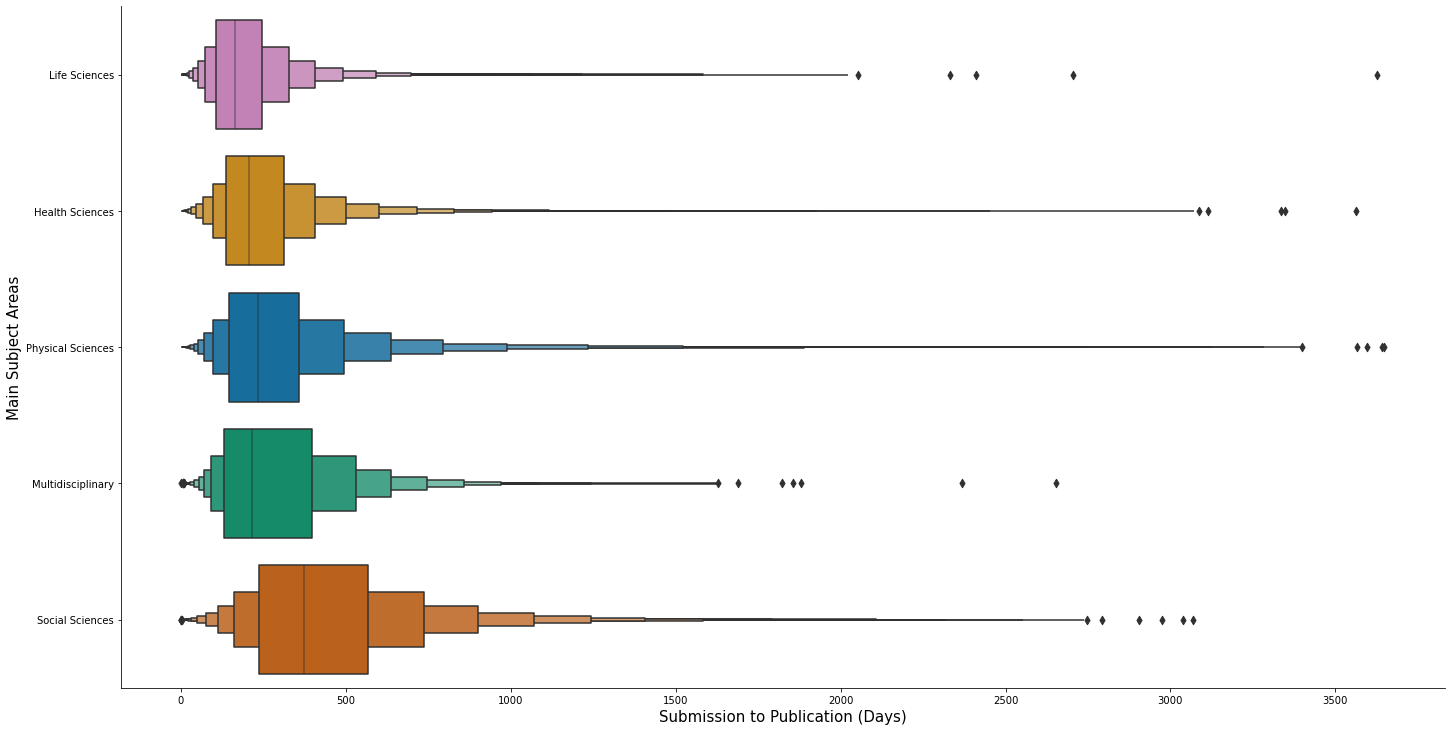

In [16]:
g = sns.catplot(
    data=q1_date_df, x='time_delta', y='Chosen_Main_SA',
    kind='boxen', height=10, aspect= 2, 
    order=sa_main_order, palette = my_sa_main_pal
) 
g.set_xlabels("Submission to Publication (Days)", fontsize=15)
g.set_ylabels("Main Subject Areas", fontsize=15)
g.despine()

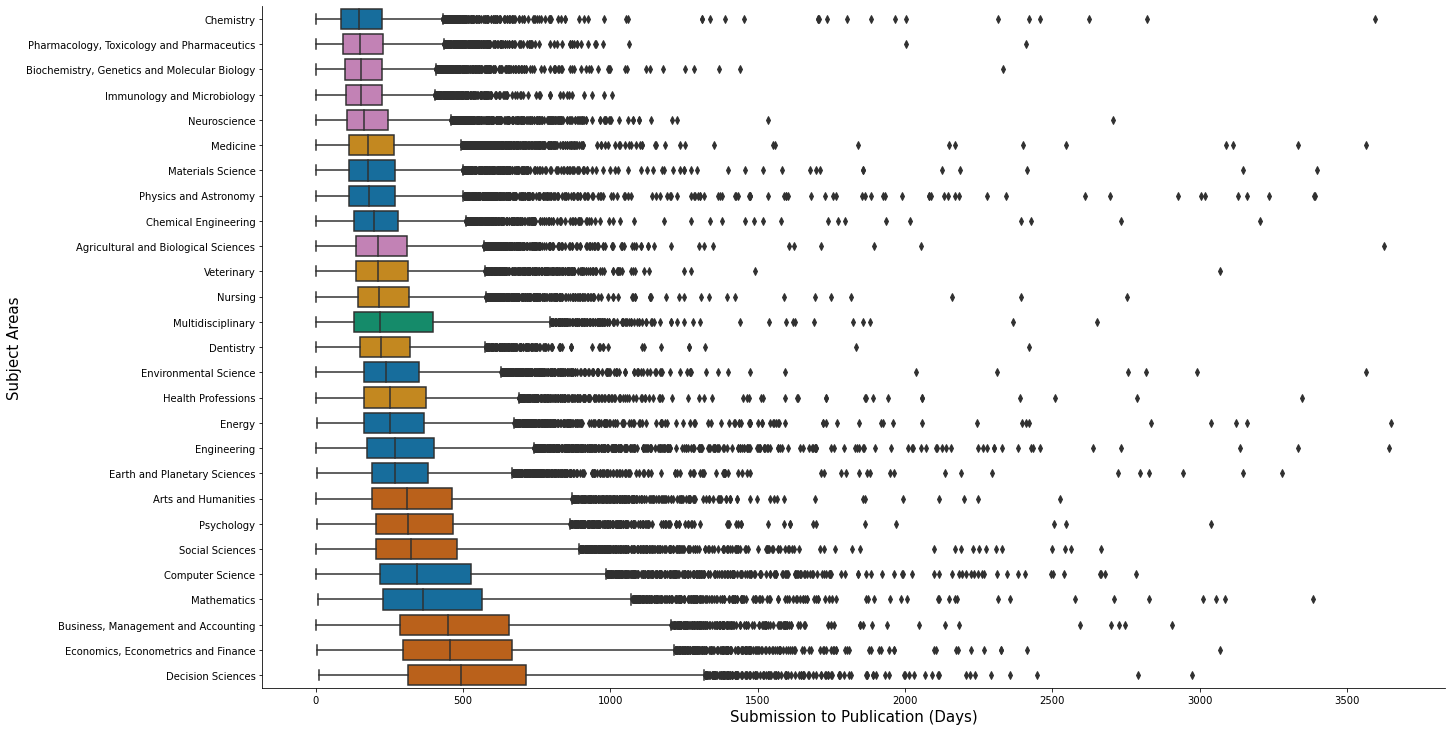

In [21]:
g = sns.catplot(
    data=q1_date_df, x='time_delta', y='Chosen_SA',
    kind='box', height=10, aspect= 2, 
    order=sa_order, palette = my_sa_pal
) 

g.
g.set_xlabels("Submission to Publication (Days)", fontsize=15)
g.set_ylabels("Subject Areas", fontsize=15)
g.despine(right=True, top=True)

In [24]:
q1_date_df["time_delta_month"] = round(q1_date_df.time_delta/30).astype(int)

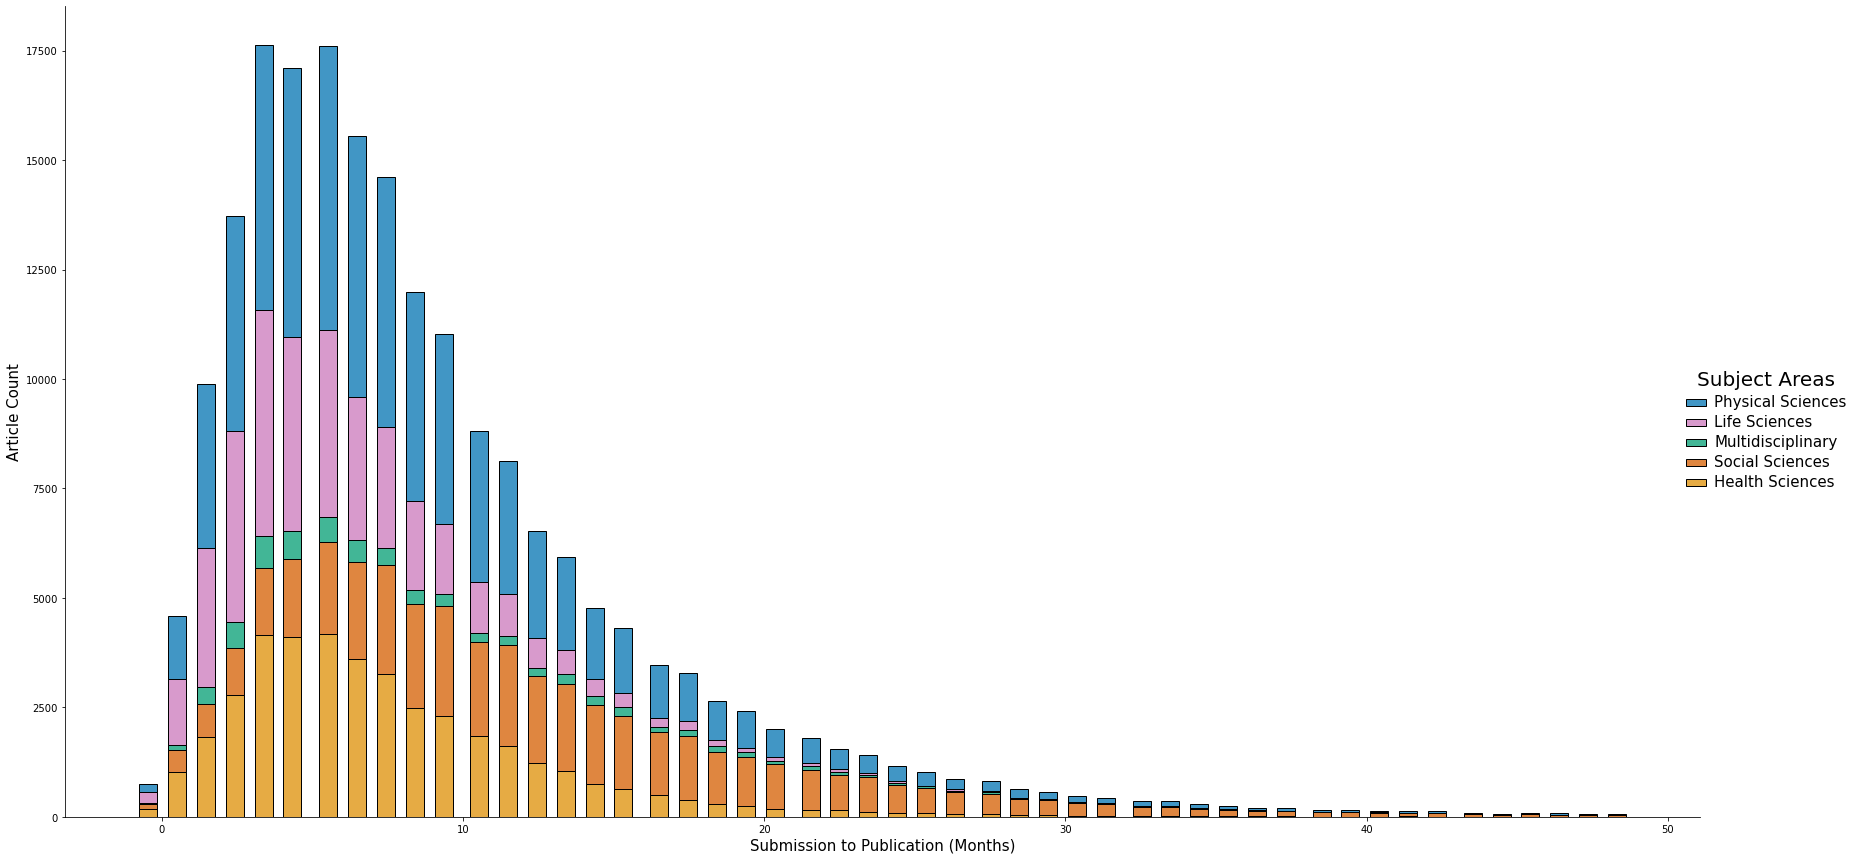

In [25]:
g = sns.displot(data=q1_date_df[q1_date_df.time_delta_month < 50], x="time_delta_month",height=12, aspect= 2, hue="Chosen_Main_SA", multiple="stack", fill=True,
palette=my_sa_main_pal, shrink=2.5)


g.set_xlabels("Submission to Publication (Months)", fontsize=15)
g.set_ylabels("Article Count", fontsize=15)

# Legend title
g.legend.set_title("Subject Areas")
g.legend.get_title().set_fontsize(20)


# Legend texts
for text in g.legend.texts:
    text.set_fontsize(15)


In [71]:
date_delta_pivot_mean = pd.pivot_table(data=q1_date_df, columns="Published_Year", index="Chosen_SA", values="time_delta", aggfunc="mean").applymap(int)

In [69]:
date_delta_pivot_median = pd.pivot_table(data=q1_date_df, columns="Published_Year", index="Chosen_SA", values="time_delta", aggfunc="median").applymap(int)

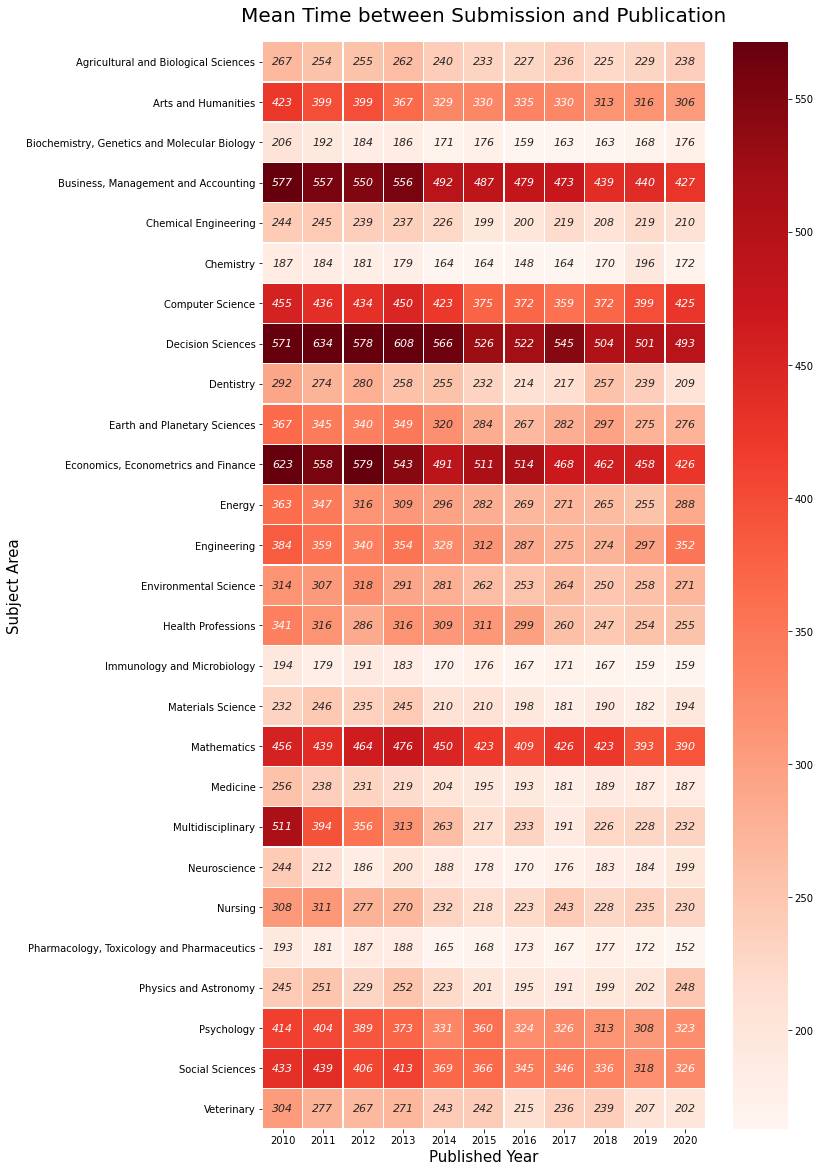

In [73]:
f, ax = plt.subplots(1,1, figsize=(10,20))

sns.color_palette("colorblind")
ax = sns.heatmap(date_delta_pivot_mean, square=True, annot=True, linewidth=0.3, ax=ax, fmt=".3g", annot_kws={"fontsize":11, "fontstyle":"italic"}, robust=True, cmap="Reds")

ax.set_xlabel("Published Year", size=15,)
ax.set_ylabel("Subject Area", size=15)
ax.set_title("Mean Time between Submission and Publication", size=20, pad=20)

# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([4,4.5,5])
# colorbar.set_ticklabels(['Low','Med','High'])
plt.show()

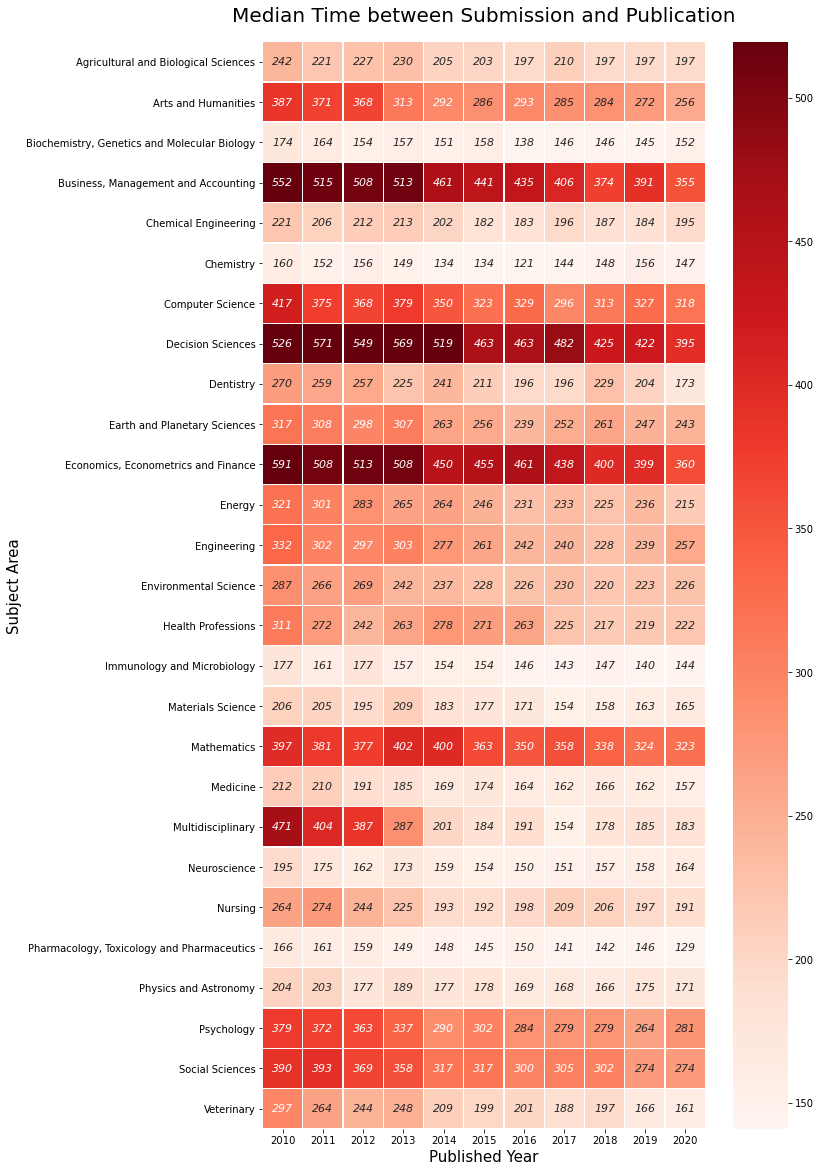

In [70]:
f, ax = plt.subplots(1,1, figsize=(10,20))

sns.color_palette("colorblind")
ax = sns.heatmap(date_delta_pivot_median, square=True, annot=True, linewidth=0.3, ax=ax, fmt=".3g", annot_kws={"fontsize":11, "fontstyle":"italic"}, robust=True, cmap="Reds")

ax.set_xlabel("Published Year", size=15,)
ax.set_ylabel("Subject Area", size=15)
ax.set_title("Median Time between Submission and Publication", size=20, pad=20)

# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([4,4.5,5])
# colorbar.set_ticklabels(['Low','Med','High'])
plt.show()

#### 3.2 - Country boxplot

In [21]:
# Adding a country column to q1_date_df:
q1_date_df["country_counter"] = q1_date_df.country_list.map(lambda x: Counter(x).most_common()[0][0])

In [22]:
country_count_order = q1_date_df.groupby("country_counter")["title"].count().sort_values(ascending=False).index.to_list()

country_time_order = q1_date_df.groupby("country_counter")["time_delta"].median().sort_values().index.to_list()

country_time_order_50 = q1_date_df[q1_date_df.country_counter.map(lambda x: x in country_count_order[:50])].groupby("country_counter")["time_delta"].median().sort_values().index.to_list()


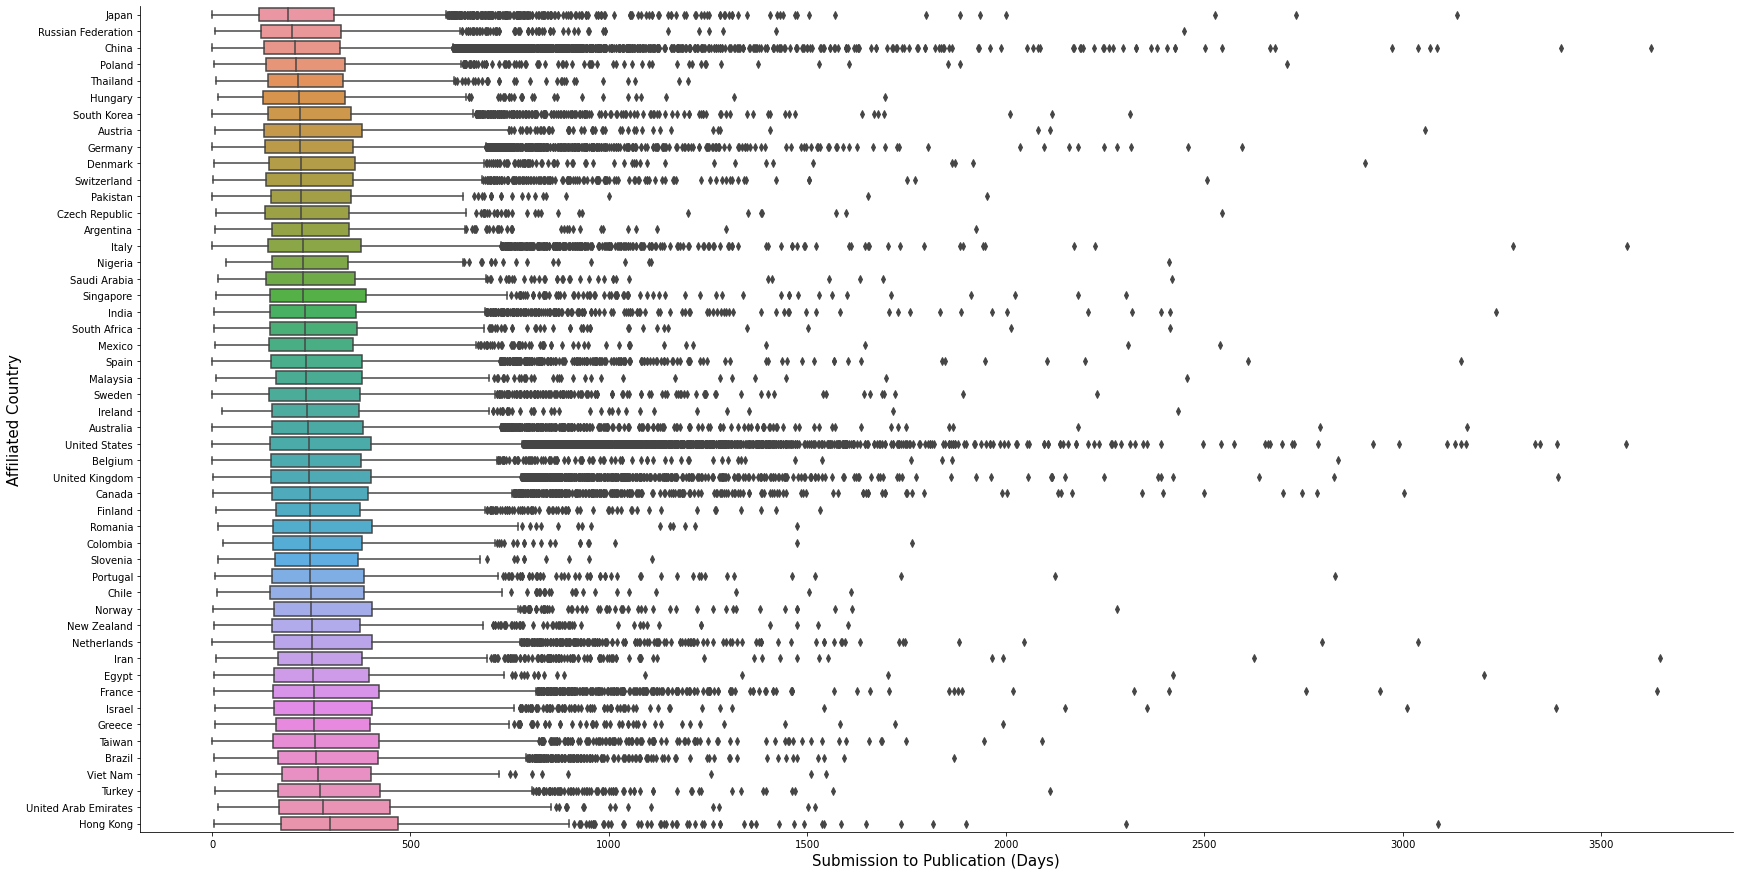

In [23]:
#my_def_pal = sns.color_palette("colorblind",50)
g = sns.catplot(
    data=q1_date_df, x='time_delta', y='country_counter',
    kind='box', height=12, aspect= 2,
    order=country_time_order_50
) 

g.set_xlabels("Submission to Publication (Days)", fontsize=15)
g.set_ylabels("Affiliated Country", fontsize=15)
g.despine()

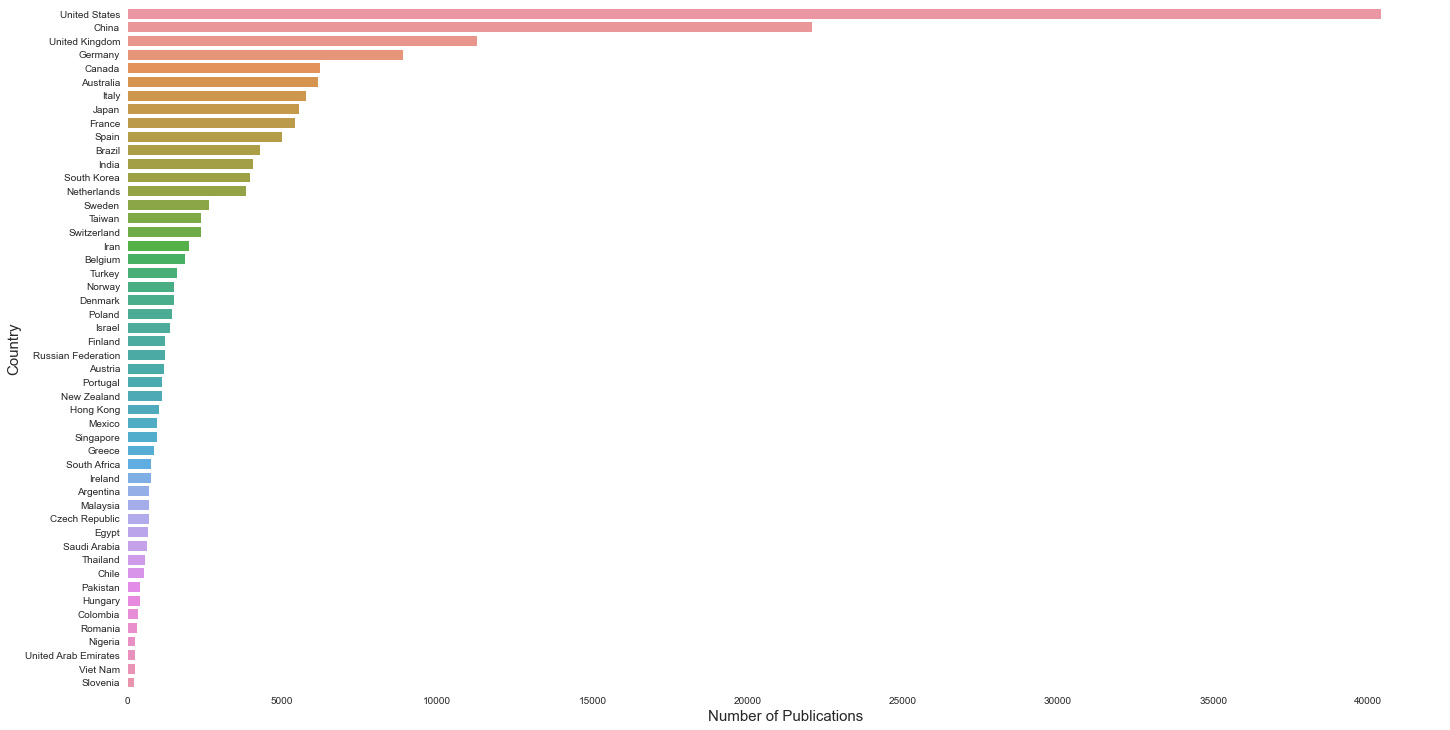

In [371]:
g= sns.catplot(
    data=q1_date_df, y='country_counter', kind='count', order=country_count_order[:50], height=10, aspect= 2
)
g.set_xlabels("Number of Publications", fontsize=15)
g.set_ylabels("Country", fontsize=15)
g.despine(left=True, bottom=True)



#### 3.3 - Year plot

In [80]:
# Adding a year column
q1_date_df["Published_Year"] = q1_date_df.Published_datetime.map(lambda x: str(x.year))

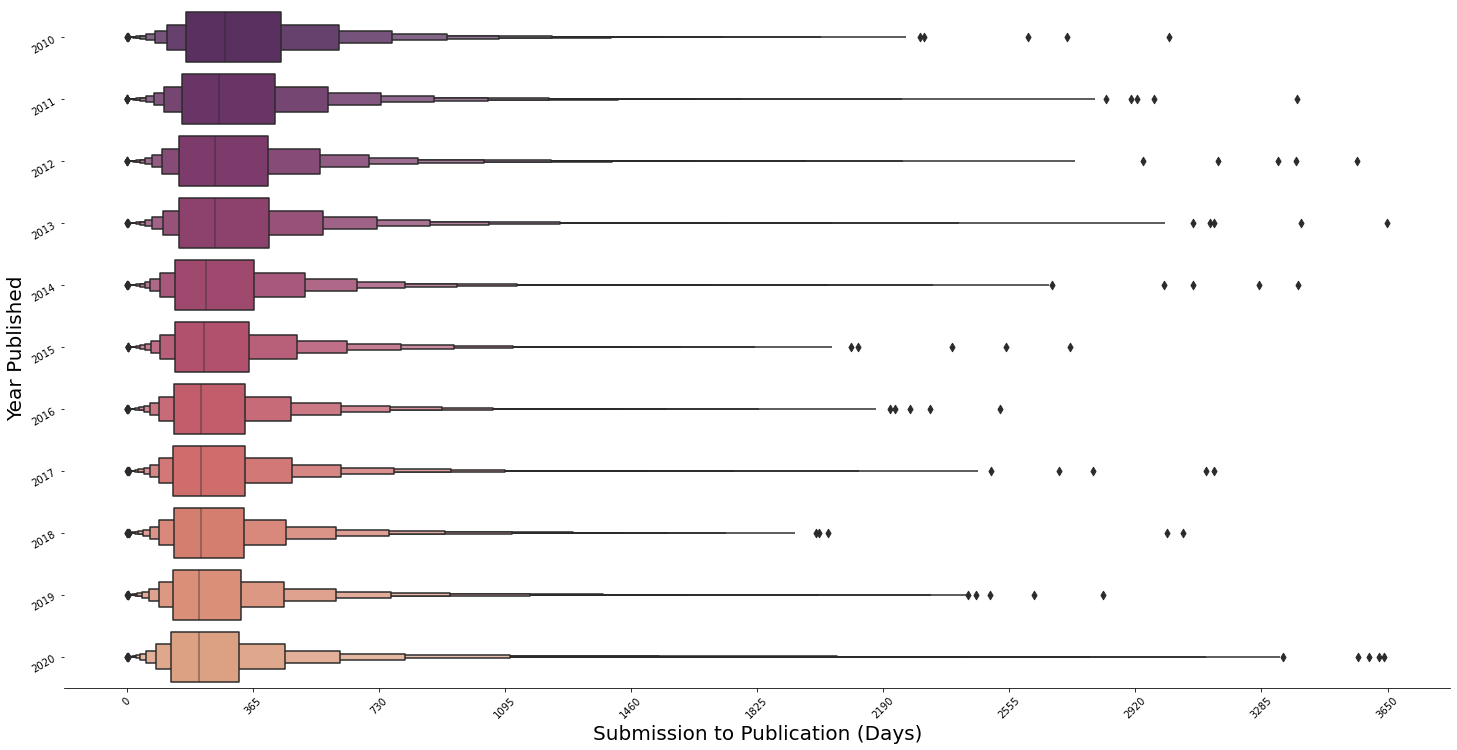

In [95]:
# my_def_pal = sns.color_palette("colorblind",50)

g = sns.catplot(
    data=q1_date_df, x='time_delta', y='Published_Year',
    kind='boxen', height=10, aspect= 2,
    order=[str(year) for year in range(2010,2021)], palette="flare_r"
)

g.set(xticks=np.arange(0,4000,365))
g.set_xticklabels(np.arange(0,4000,365), rotation=45)

g.set_xlabels("Submission to Publication (Days)", fontsize=20)
g.set_ylabels("Year Published", fontsize=20)
g.set_yticklabels(rotation=30, fontsize=10)
g.despine(left=True)

#### 3.4 - Detailed Graphs

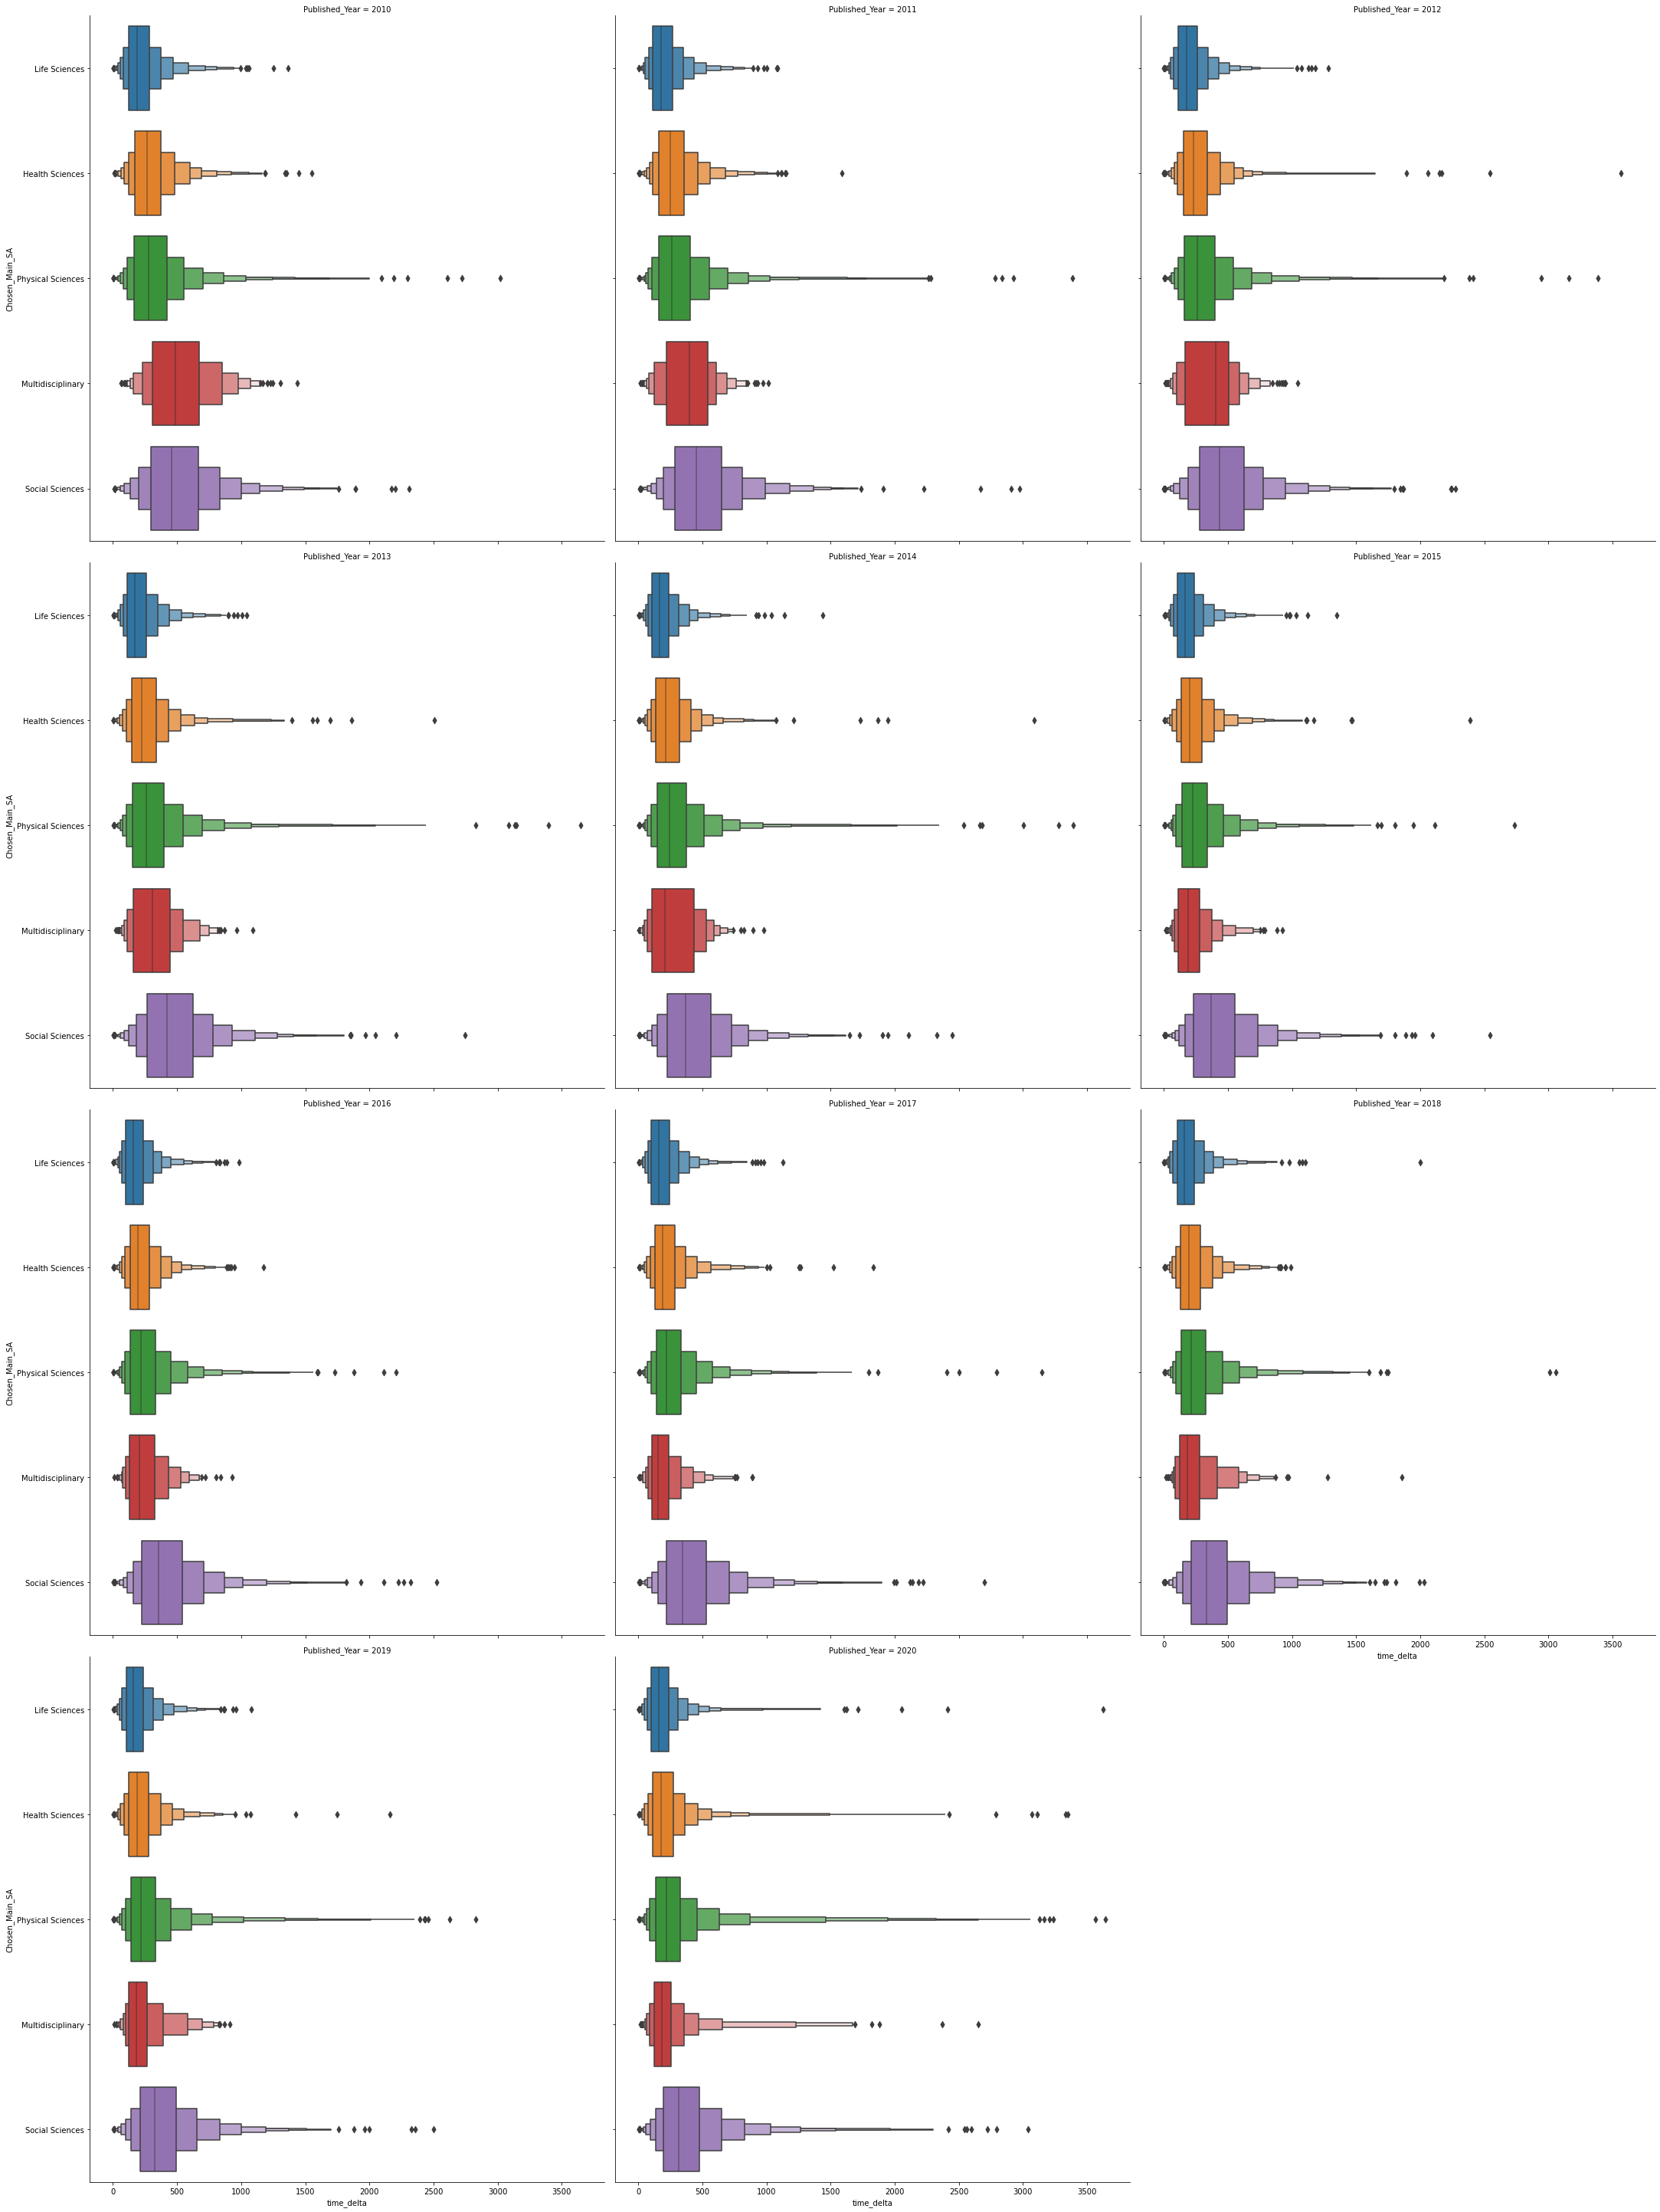

In [221]:
sns.catplot(
    data=q1_date_df, x='time_delta', y='Chosen_Main_SA',
    col='Published_Year', kind='boxen', col_wrap=3, height=10, aspect= 1, 
    col_order=[str(year) for year in range(2010,2021)], order=sa_main_order
)

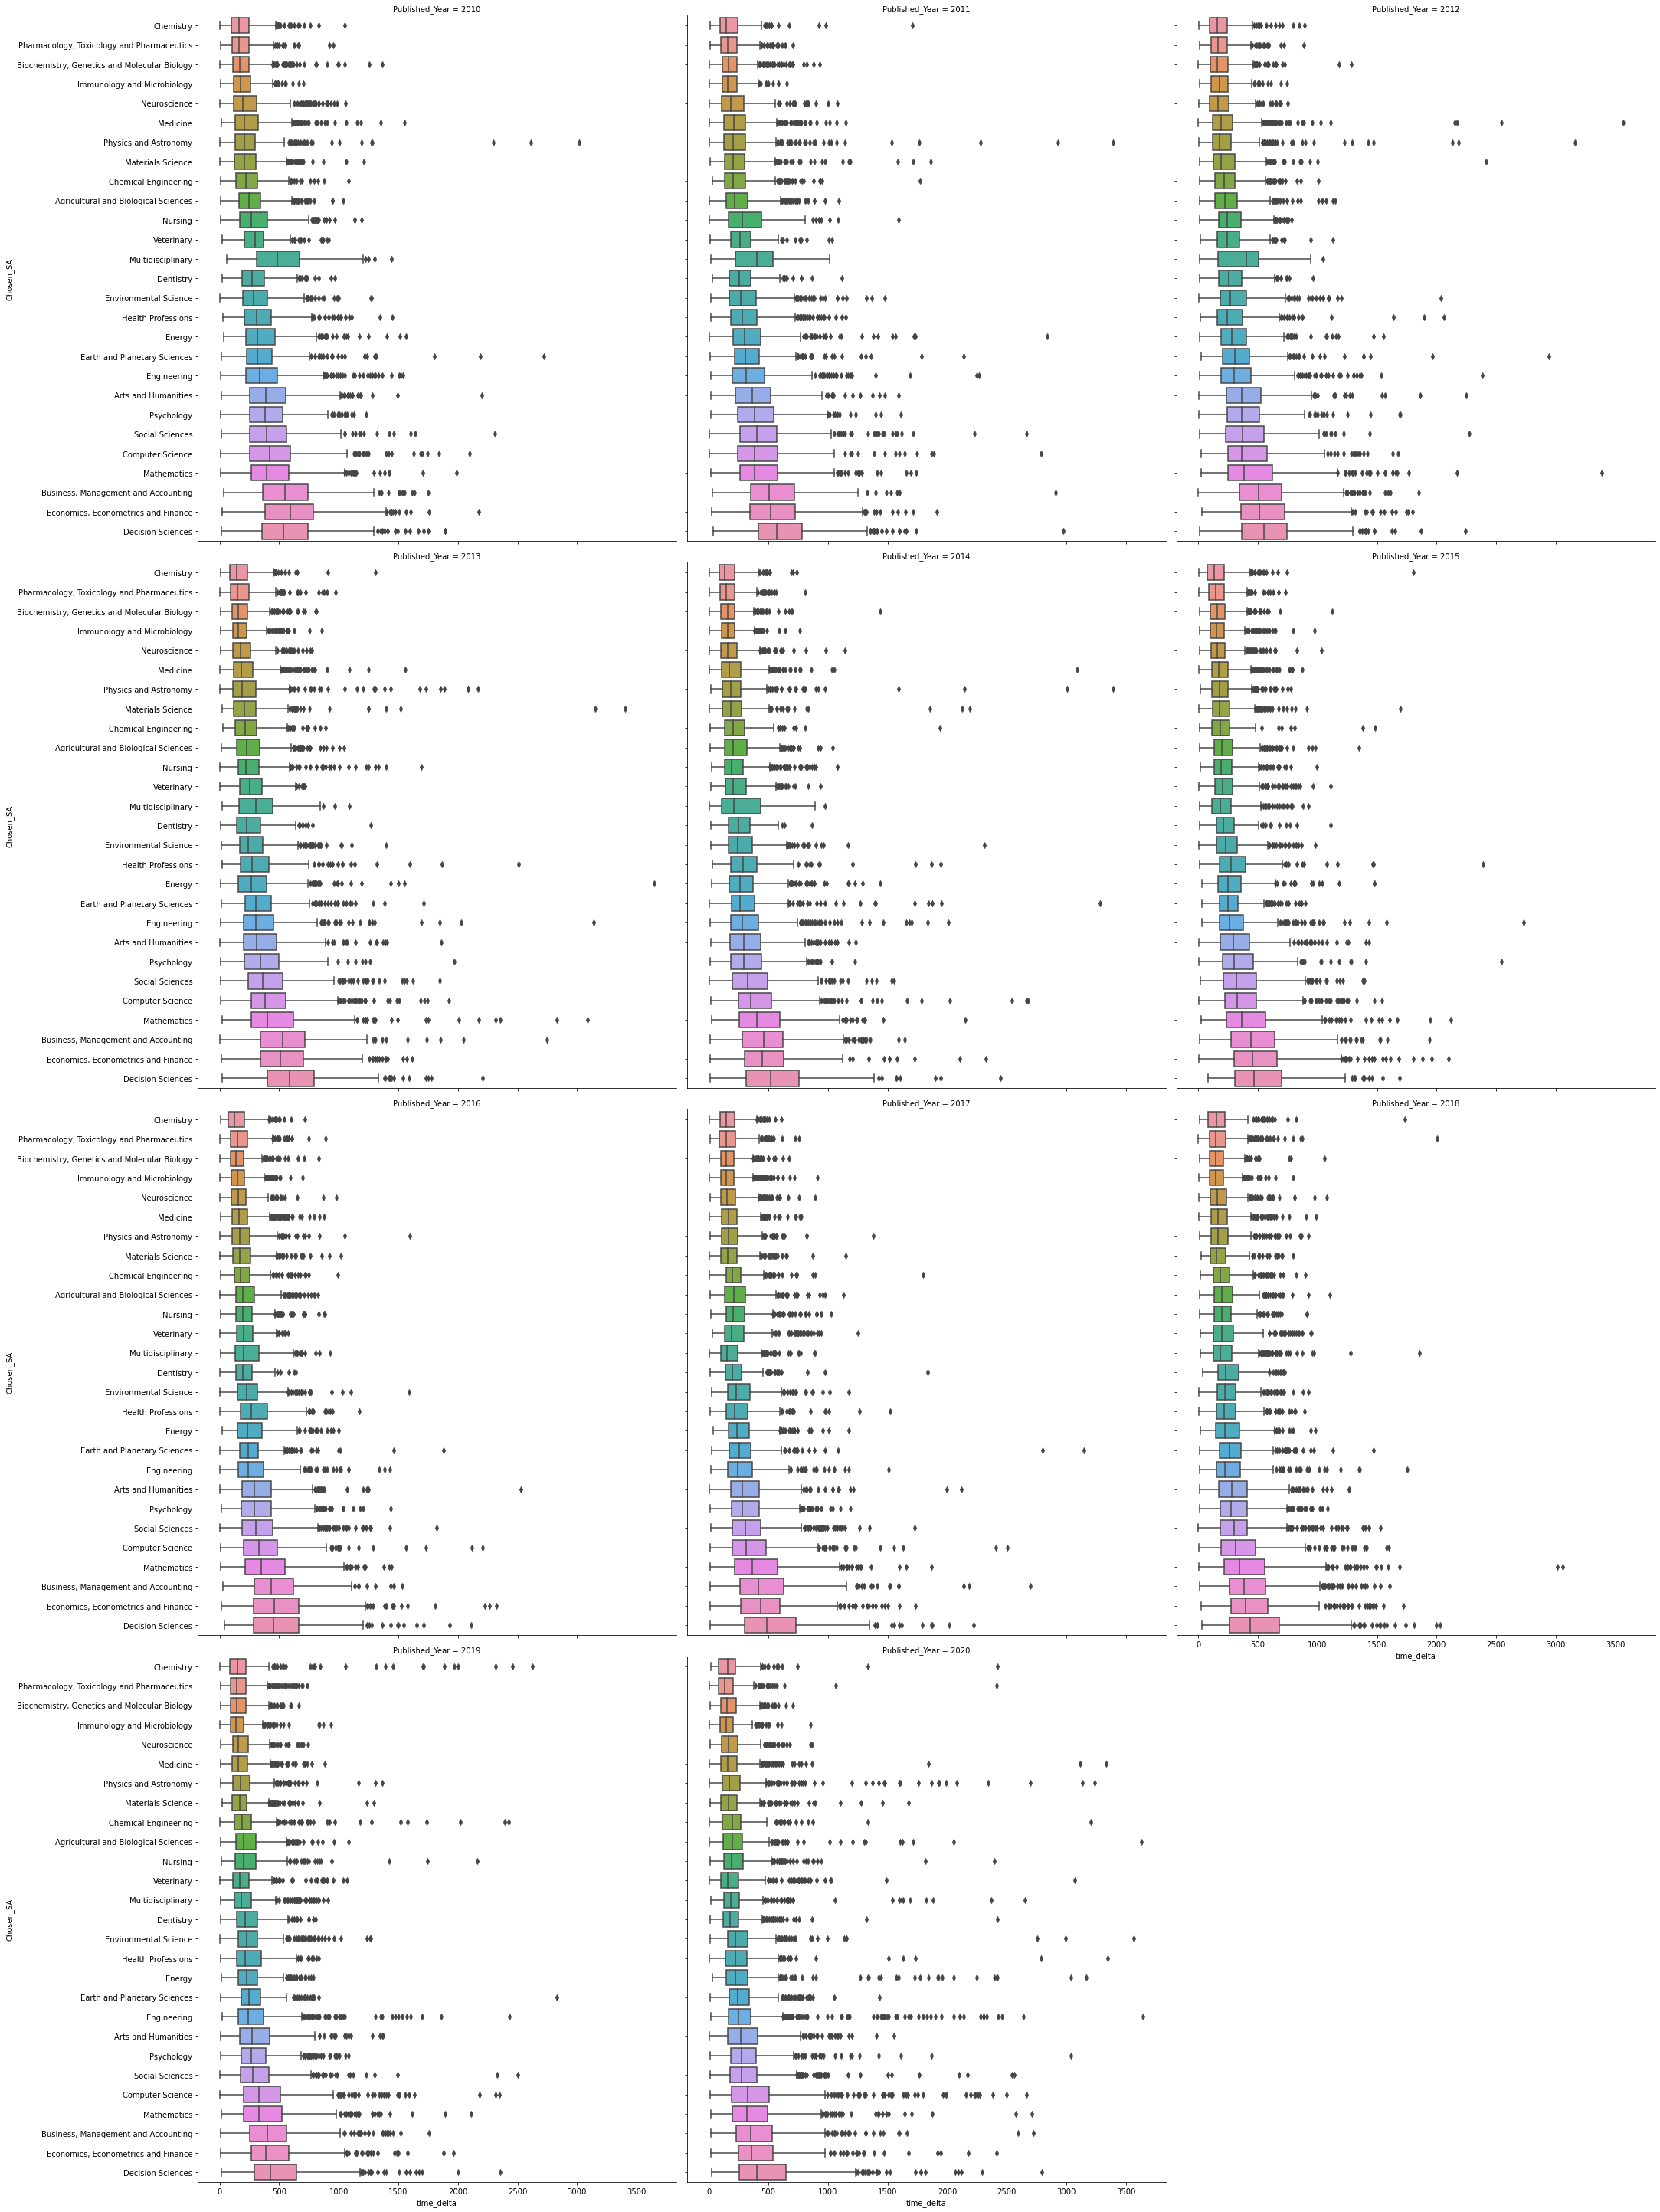

In [193]:
sns.catplot(
    data=q1_date_df, x='time_delta', y='Chosen_SA',
    col='Published_Year', kind='box', col_wrap=3, height=10, aspect= 1, 
    col_order=[str(year) for year in range(2010,2021)], order=sa_order,
)

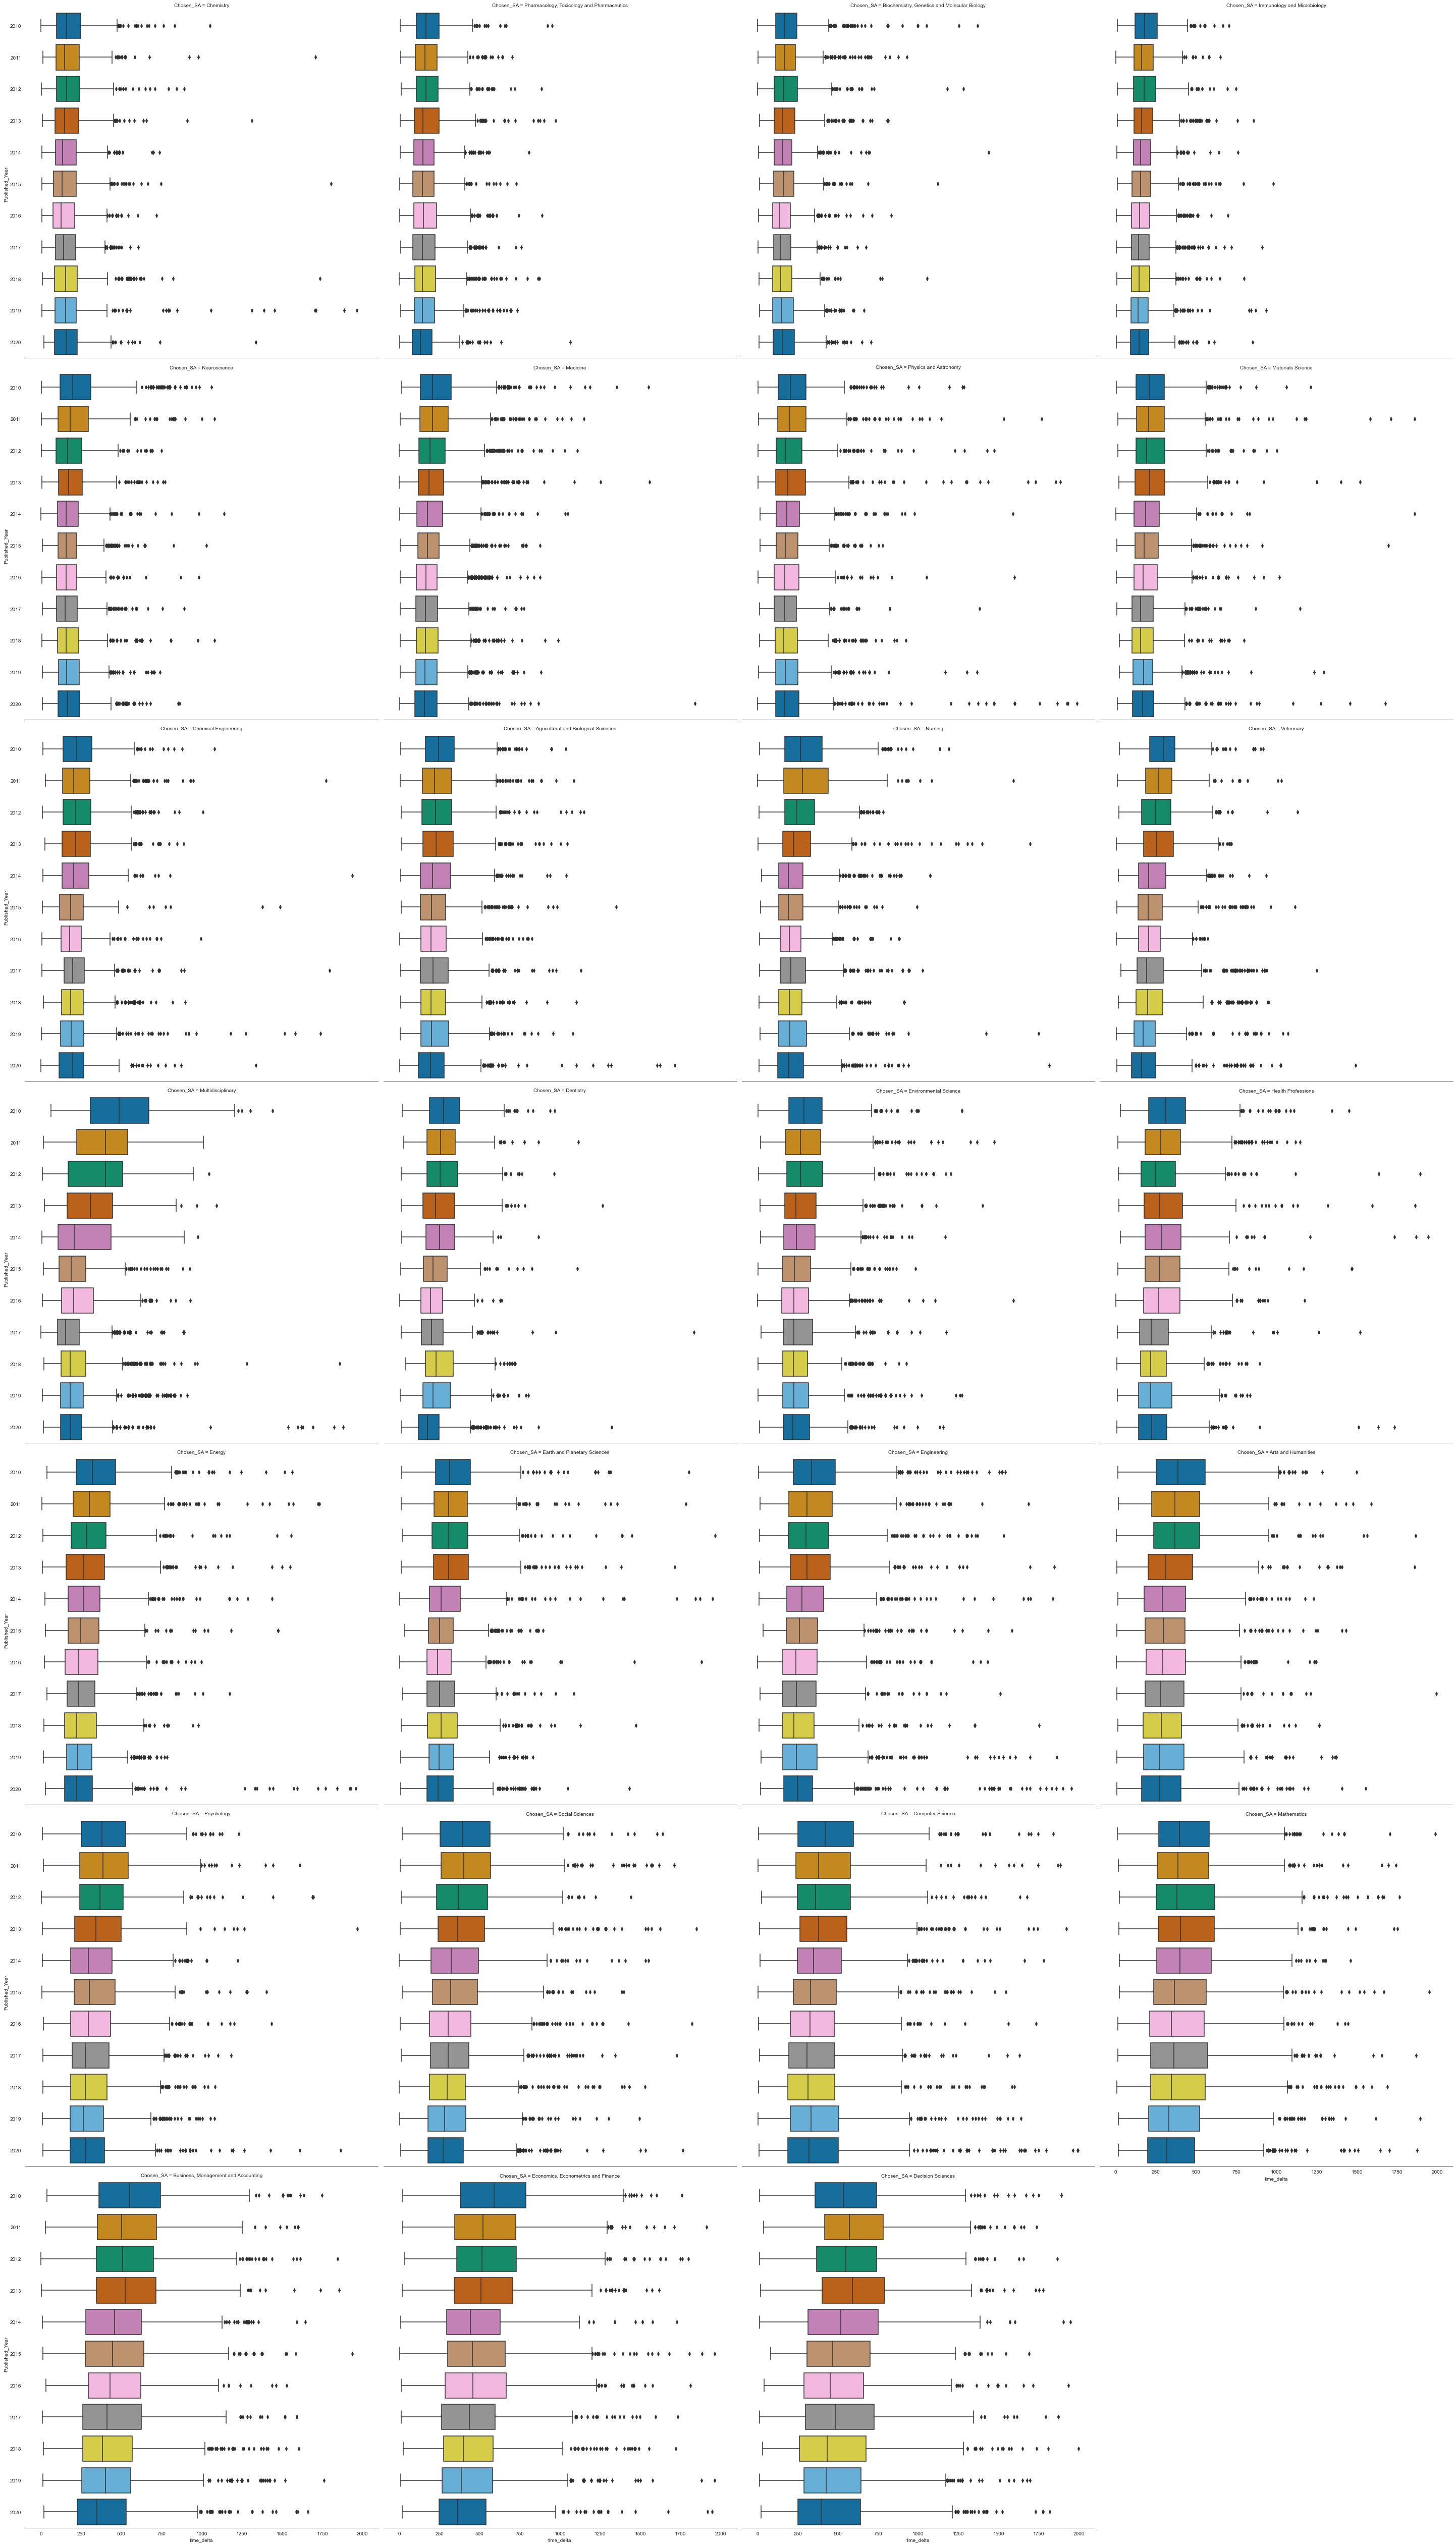

In [338]:
sns.set_style("white")
g = sns.catplot(
    data=q1_date_df[q1_date_df.time_delta < 2000], x='time_delta', col='Chosen_SA', col_order=sa_order,
    y='Published_Year', kind='box', col_wrap=4, height=10, aspect= 1, palette="colorblind",
    order=[str(year) for year in range(2010,2021)], sharey=True, sharex=True)

g.despine(left=True)

#### 3.5 - Publisher Analysis

In [49]:
publisher_list = q1_date_df.publisher.value_counts().index.to_list()

In [52]:
# publisher_time_order = q1_date_df.groupby("country_counter")["publisher"].median().sort_values().index.to_list()
publisher_time_order_20 = q1_date_df[q1_date_df.publisher.map(lambda x: x in publisher_list[:20])].groupby("publisher")["time_delta"].median().sort_values().index.to_list()


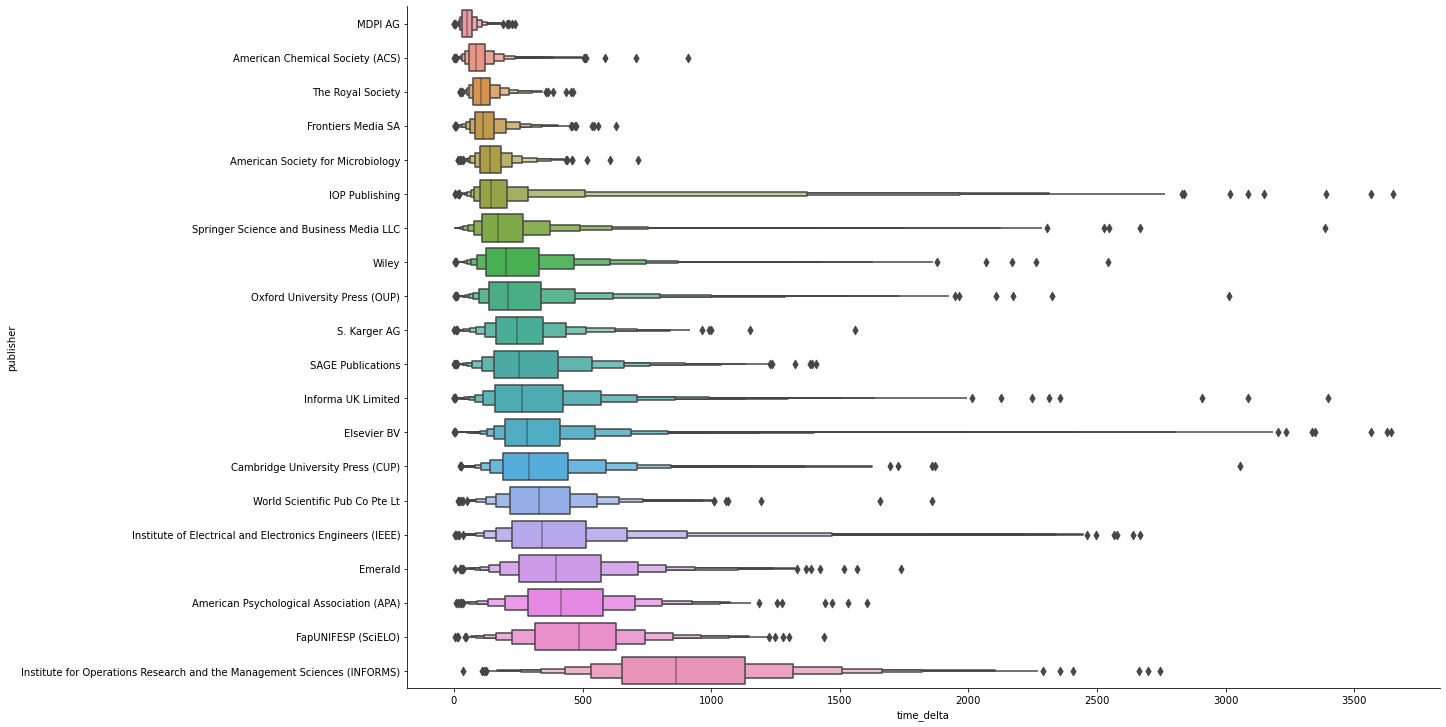

In [53]:
#my_def_pal = sns.color_palette("colorblind",50)

g = sns.catplot(
    data=q1_date_df[q1_date_df.publisher.map(lambda x: x in publisher_list[:20])], x='time_delta', y='publisher',
    kind='boxen', height=10, aspect= 2, order = publisher_time_order_20
) 

# g.set_xlabels("Submission to Publication (Days)", fontsize=20)
# g.set_ylabels("Year Published", fontsize=20)
# g.set_yticklabels(rotation=30, fontsize=10)
# g.tight_layout()
# g.despine(left=True)

#### 3.6 - References & Doc Counts

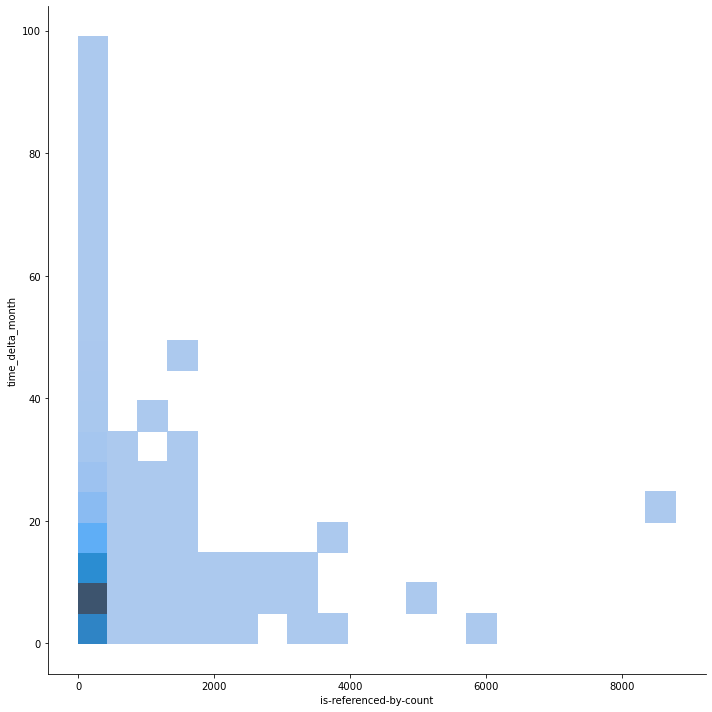

In [105]:
g = sns.displot(
    data=q1_date_df[q1_date_df.time_delta_month < 100], y='time_delta_month', x='is-referenced-by-count', bins = 20,
    height=10, aspect= 1
    )

# g.set_xlabels("Submission to Publication (Days)", fontsize=20)
# g.set_ylabels("Year Published", fontsize=20)
# g.set_yticklabels(rotation=30, fontsize=10)
# g.tight_layout()
# g.despine(left=True)

In [72]:
q1_first_author_df["first_doc_count"] = q1_first_author_df.doc_count.map(lambda x: x[0])

In [73]:
def doc_count_mapper(auth_list):
    doc_count_list = list()
    for auth in auth_list:
        doc_count_list.append(q1_first_author_df.loc[auth,"first_doc_count"])
    return doc_count_list


In [74]:
q1_date_df["doc_count_list"] = q1_date_df.AUTH_ID.map(doc_count_mapper)

In [78]:
q1_date_df.doc_count_list.isna().sum()

0

In [83]:
q1_date_df["avg_doc_count"] = q1_date_df.doc_count_list.map(lambda x: np.mean([int(y) for y in x]))

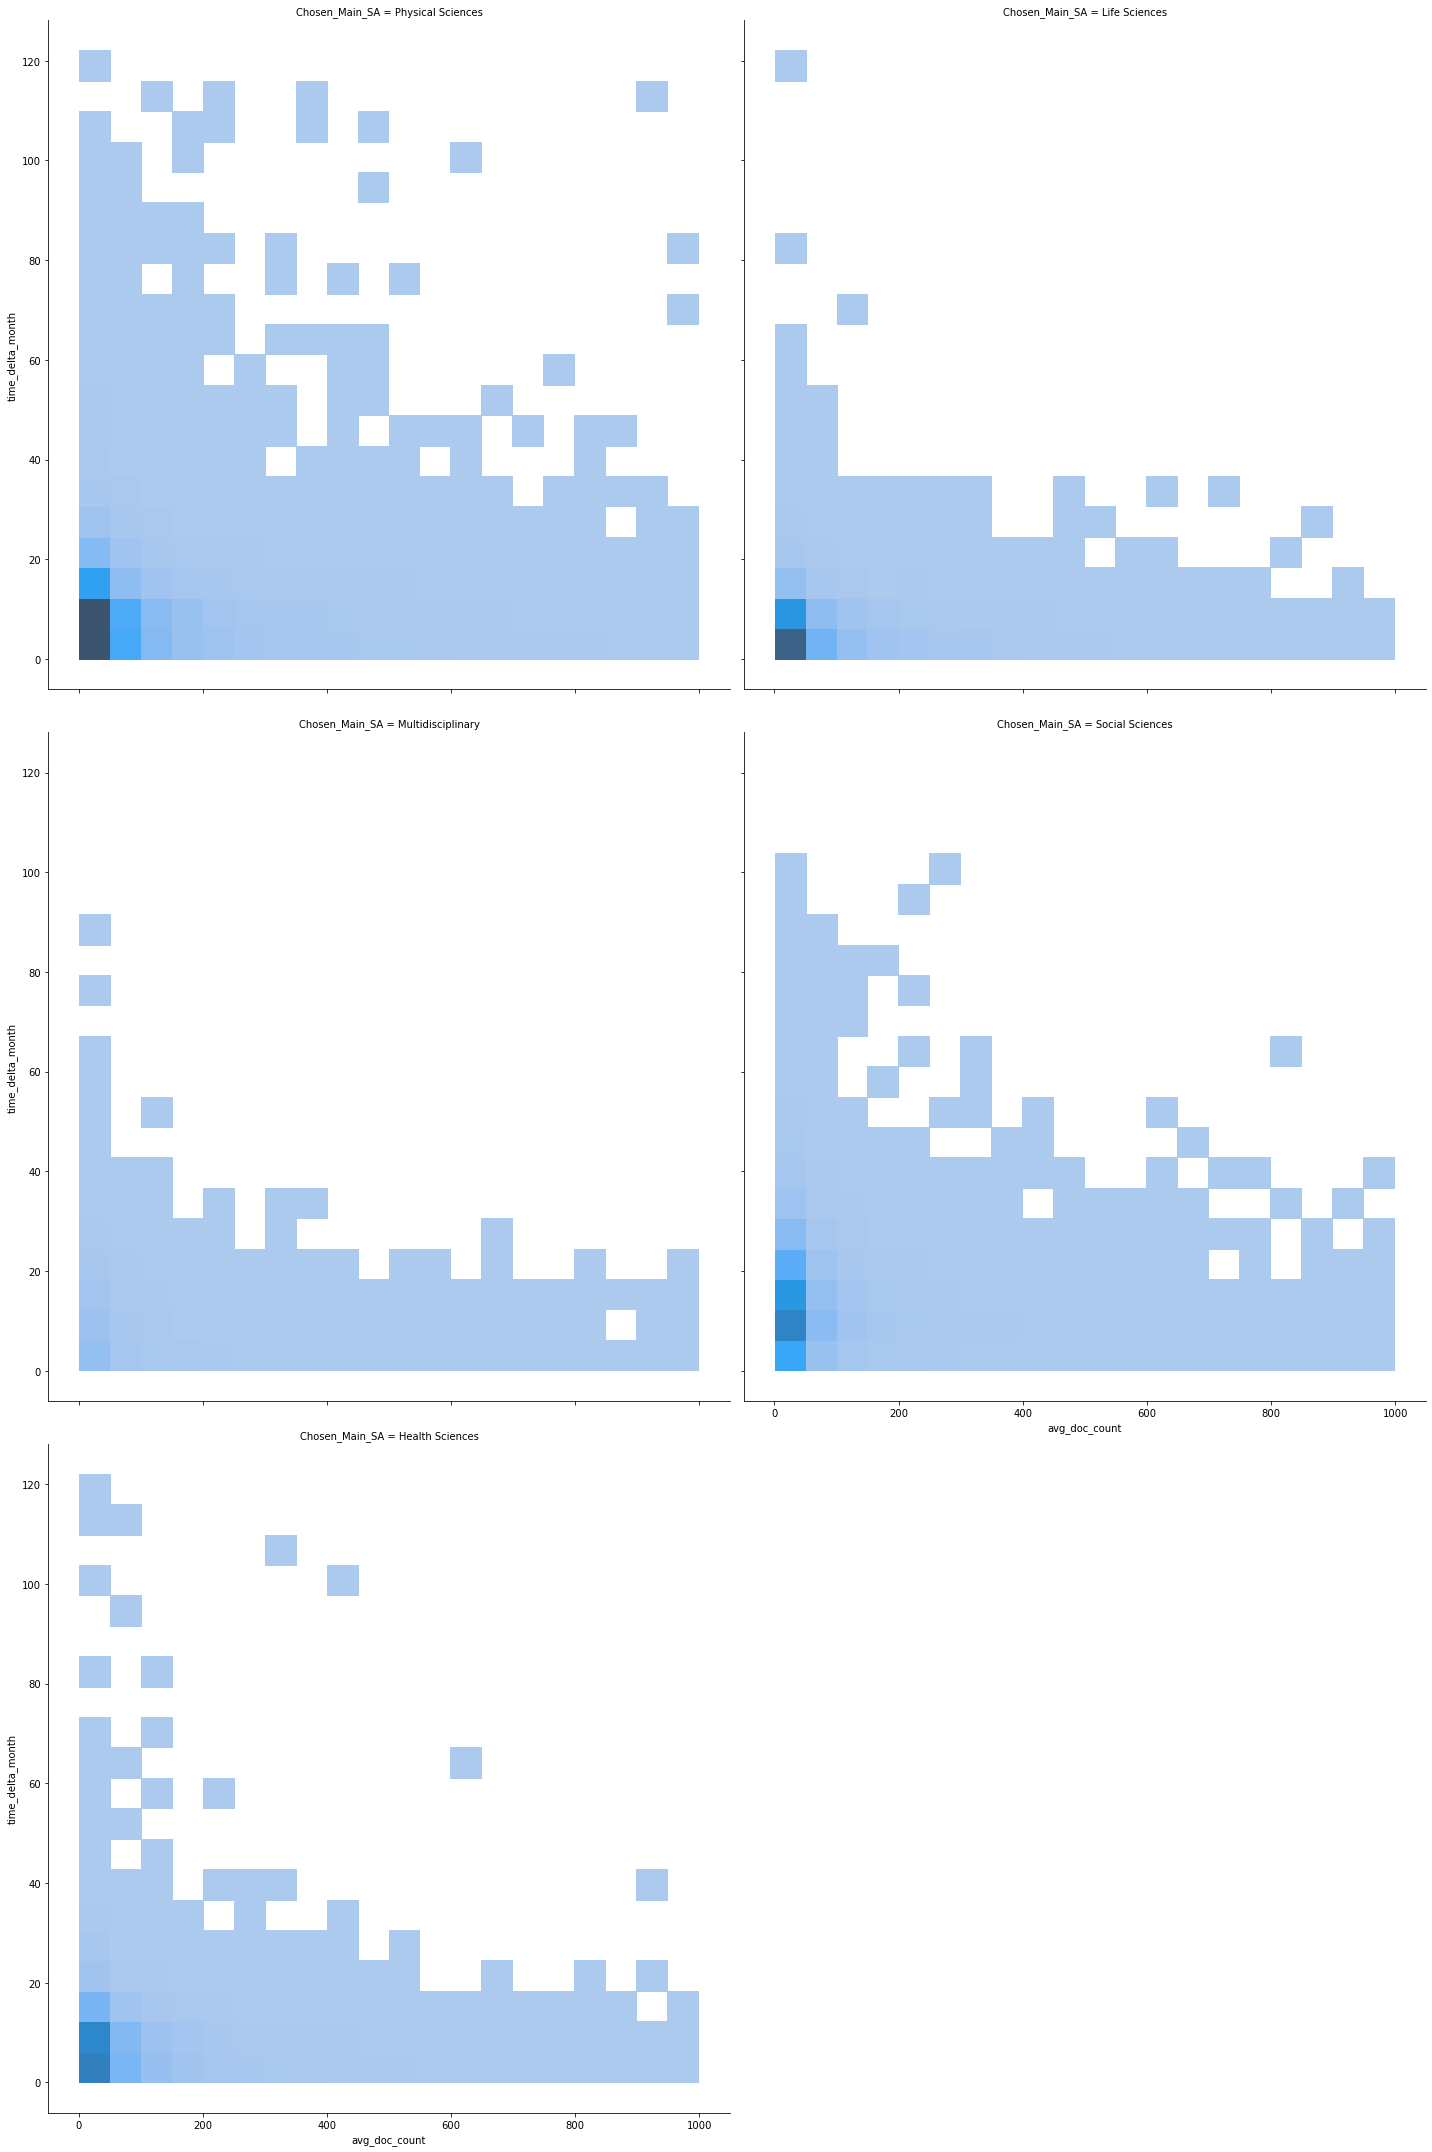

In [108]:
g = sns.displot(
    data=q1_date_df[q1_date_df.avg_doc_count <1000], y='time_delta_month', x='avg_doc_count', col="Chosen_Main_SA", col_wrap=2, bins=20,
    height=10, aspect= 1
    )

# g.set_xlabels("Submission to Publication (Days)", fontsize=20)
# g.set_ylabels("Year Published", fontsize=20)
# g.set_yticklabels(rotation=30, fontsize=10)
# g.tight_layout()
# g.despine(left=True)

#### Graph Functions from UL project:

In [ ]:
# Heatmap Function:

def draw_heatmap(df,legend,figsize=(20,14)):

    my_colors = ['darkred', 'orange', 'green']
    my_cmap = ListedColormap(my_colors)
    bounds = [0, 4, 4.50, 5]
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    if legend == "vertical":
        f, ax = plt.subplots(1,1, figsize=figsize)

        sns.color_palette()
        ax = sns.heatmap(df, square=True, annot=True, linewidth=0.3, ax=ax, annot_kws={"fontsize":15},
                cmap=my_cmap,
                norm=my_norm)

        ax.set_xlabel("")
        ax.set_ylabel("")

        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([4,4.5,5])
        colorbar.set_ticklabels(['Low','Med','High'])


    elif legend == "horizontal":
        grid_kws = {"height_ratios": (.95, .05)}
        f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=figsize)

        sns.color_palette()
        ax = sns.heatmap(df, square=True, annot=True, linewidth=0.3, ax=ax, annot_kws={"fontsize":15},
                cbar_ax=cbar_ax,
                cmap=my_cmap,
                norm=my_norm,
                cbar_kws={"orientation": "horizontal"})


        ax.set_xlabel("")
        ax.set_ylabel("")

        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([4,4.5,5])
        colorbar.set_ticklabels(['Low','Med','High'])

    elif legend==False:
        f, ax = plt.subplots(1,1, figsize=figsize)

        my_colors = ['darkred', 'orange', 'green']
        my_cmap = ListedColormap(my_colors)
        bounds = [0, 4, 4.50, 5]
        my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

        sns.color_palette()
        ax = sns.heatmap(df, square=True, annot=True, linewidth=0.3, ax=ax, annot_kws={"fontsize":15},
                        cbar =False,
                        cmap=my_cmap,
                        norm=my_norm)

        ax.set_xlabel("")
        ax.set_ylabel("")


    plt.show()


In [ ]:
# Heatmap Function:

# df: dataframe
# mode: "SKU" or "brand"
# figsize: graph size
# vertical: vertical if True 
# all_categs: displays all categories if True (even if the brand/SKU does not have any reviews in that category)
# annot: displays the category average if True

def single_heatmap(df, mode, name, figsize=(16,8), vertical=False, all_categs=False, annot=False):

    if mode == "SKU":
        heat_df = df[df.product_name == name].groupby("attr_list")["review_rating"].mean().sort_values(ascending=False).to_frame().transpose()
        
        count_df = df[df.product_name == name].groupby("attr_list")["review_rating"].count().to_frame().transpose()
        count_sum = count_df.sum(axis=1)[0]
        count_df = count_df/count_sum  * 100
        
        print(f'{name} - Avg. Score: {round(df[df.product_name == name]["review_rating"].mean(),2)}')
        print(f"{name} Total Comments: {count_sum}")



    elif mode == "brand":
        heat_df = df[df.product_brand == name].groupby("attr_list")["review_rating"].mean().sort_values(ascending=False).to_frame().transpose()
        
        count_df = df[df.product_brand == name].groupby("attr_list")["review_rating"].count().to_frame().transpose()
        count_sum = count_df.sum(axis=1)[0]
        count_df = round(count_df/count_sum * 100, 1)


        print(f'{name} - Avg. Score: {round(df[df.product_brand == name]["review_rating"].mean(),2)}')
        print(f"{name} Total Comments: {count_sum}")


    if all_categs == True:
        columns_df = pd.DataFrame(columns=df.attr_list.unique())
        heat_df = pd.concat([columns_df,heat_df])
        count_df = pd.concat([columns_df,count_df])

    else:
        col_order = heat_df.columns.tolist()
        count_df = count_df.loc[:,col_order]


    if vertical == True:
        heat_df = heat_df.transpose()
        count_df = count_df.transpose()
        nrows, ncols = 1,2
        figsize = (figsize[1],figsize[0])
    else:
        nrows, ncols = 2,1
    
    f, (ax1,ax2) = plt.subplots(nrows, ncols, figsize=figsize)

    my_colors = ['darkred', 'orange', 'green']
    my_cmap = ListedColormap(my_colors)
    bounds = [0, 4, 4.50, 5]
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    my_colors2 = ['lightskyblue', 'skyblue', 'deepskyblue', 'steelblue']
    my_norm2 = BoundaryNorm([0,10,20,23,50],ncolors=4)

    sns.color_palette()
    ax1 = sns.heatmap(heat_df, square=True, annot=annot, linewidth=0.1, ax=ax1, annot_kws={"fontsize":12},
                    cbar =False,
                    cmap=my_cmap,
                    norm=my_norm)
    
    ax1.set_title(name, fontdict={'fontsize': 15}, pad=10)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
        

    ax2 = sns.heatmap(count_df, square=True, annot=annot, linewidth=0.1, ax=ax2, annot_kws={"fontsize":15}, cbar=False,cmap=my_colors2,  norm=my_norm2)
    ax2.set_title(f"{name} Comment Percentages (%):", fontdict={'fontsize': 15}, pad=10)
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    

    if vertical == True:
        ax1.get_xaxis().set_visible(False)
        ax2.get_xaxis().set_visible(False)
        
    else:
        ax1.get_yaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
    
    plt.show()

    
